In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import regex as re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aguti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Funciones para armar el dataset

In [3]:
import os
def get_hashtags_text(x):
    if pd.notna(x) and 'hashtags' in x and x['hashtags']:
        hashtags = x['hashtags']
        hashtags_text = [ht['text'] for ht in hashtags]
        return hashtags_text
    else:
        return None

def get_urls(x):
    if pd.notna(x) and 'urls' in x and x['urls']:
        return True
    return False


def get_user_location(x):
    if pd.notna(x) and 'location' in x:
        return x['location']
    else:
        return None


def load_json(file_path):
    df_new = pd.DataFrame()

    try:
        # Leer el archivo JSON línea por línea y cargar los datos en una lista
        datos_json = []
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                data = json.loads(line)
                if 'retweeted_status' in data and data['retweeted_status'] != None:
                    data = data['retweeted_status']
                datos_json.append(data)

        df = pd.DataFrame(datos_json)

        df_new['id'] = df['id']
        df_new['lang'] = df['lang']
        df_new['text'] = df['text']
        df_new['favorite_count'] = df['favorite_count']
        df_new['retweet_count'] = df['retweet_count']
        df_new['possibly_sensitive'] = df['possibly_sensitive']
        df_new['created_at'] = df['created_at']
        df_new['is_quote_status'] = df['is_quote_status']
        df_new['entities_hashtags_text'] = df['entities'].apply(get_hashtags_text)
        df_new['entities_urls'] = df['entities'].apply(get_urls)
        df_new['user_location'] = df['user'].apply(get_user_location)
        
        # Asignar 0 a las columnas 'reply_count' y 'quote_count' si no existen
        df_new['reply_count'] = df.get('reply_count', 0)
        df_new['quote_count'] = df.get('quote_count', 0)

        # Verificar si hay al menos una imagen en el JSON
        has_image = []
        for i in range(len(df)):
            try:
                extended_entities = df['extended_entities'][i]
                if 'media' in extended_entities and len(extended_entities['media']) > 0:
                    has_image.append(True)
                else:
                    has_image.append(False)
            except (KeyError, TypeError):
                has_image.append(False)

        df_new['has_image'] = has_image

    except Exception as e:
        print(f'Se produjo una excepción: {e}')

    # Retornar el DataFrame resultante
    return df_new


def load_jsons_from_folder(folder_path):
    df_all = pd.DataFrame()

    try:
        # Obtener la lista de archivos en la carpeta
        json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

        for file_name in json_files:
            file_path = os.path.join(folder_path, file_name)
            df = load_json(file_path)

            # Extraer el nombre del archivo sin "_final_data.json"
            json_name = file_name.replace('_final_data.json', '')

            # Agregar columna con el nombre del JSON
            df['json_name'] = json_name

            # Concatenar el DataFrame al DataFrame total
            df_all = pd.concat([df_all, df], ignore_index=True)

    except Exception as e:
        print(f'Se produjo una excepción: {e}')

    # Retornar el DataFrame resultante
    return df_all

def read_tsv_folder(folder_path):
    df_combined = pd.DataFrame()  # DataFrame combinado para almacenar los datos de todos los archivos TSV

    # Obtener la lista de archivos en la carpeta
    file_list = os.listdir(folder_path)

    # Leer cada archivo TSV y combinar los datos en el DataFrame combinado
    for file_name in file_list:
        if file_name.endswith(".tsv"):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, sep="\t")
            df_combined = pd.concat([df_combined, df], ignore_index=True)

    return df_combined



In [4]:
# Filtrar las filas sin imágenes
#df_without_images = harvey_json.loc[harvey_json['has_image'] == 0]
#df_without_images

df_json = load_jsons_from_folder("RDATA/CrisisMMD_v2.0/json")
df_tsv = read_tsv_folder("RDATA/CrisisMMD_v2.0/annotations")

#df_tsv

### Merge datasets

In [5]:
df_json = load_jsons_from_folder("RDATA/CrisisMMD_v2.0/json")
df_tsv = read_tsv_folder("RDATA/CrisisMMD_v2.0/annotations")


In [6]:
df = pd.merge(df_json, df_tsv[['tweet_id', 'text_info', 'text_info_conf', 'text_human', 'text_human_conf']],
                    left_on='id', right_on='tweet_id', how='left')
df.drop('tweet_id',axis=1,inplace=True)
df_con_nan = df.copy()
df =  df[df['text_human'].notna()]
print(df.shape)
df_con_nan.T



(15477, 19)


,0,1,2,3,4,5,6,7,8,9,...,17622,17623,17624,17625,17626,17627,17628,17629,17630,17631
id,917791130590183424,917787635946524674,917500054742605829,917623252264062976,917792930315821057,917792147700465664,917715928271507456,917794232160661505,917433167014920192,917793736918216706,...,881612317317836800,881612317317836800,881612317317836800,881612317317836800,881632991776301056,881714673157980160,881749861871362049,881770990556131328,881807298930368513,869578299487404032
lang,en,en,en,en,en,en,en,en,en,en,...,en,en,en,en,en,en,en,en,en,en
text,PHOTOS: Deadly wildfires rage in California ht...,Wildfires raging through Northern California a...,"PLS SHARE: We’re capturing wildfire response, ...",California's raging wildfires as you've never ...,Mass Evacuations in California as Wildfires Ki...,Wildfires Threaten California’s First Legal Ca...,Southern California fire shrouds Disneyland An...,At Least 11 Dead and 100 Missing as Wildfires ...,California wildfires destroy more than 50 stru...,California wildfire. ὡ4 https://t.co/a8oD5rkDdI,...,"Mora, Lakin, Immaris, and our DM are officiall...","Mora, Lakin, Immaris, and our DM are officiall...","Mora, Lakin, Immaris, and our DM are officiall...","Mora, Lakin, Immaris, and our DM are officiall...",https://t.co/7VqAlUWTUO My #wine tip for this ...,Get to mora and try the whole menu https://t.c...,"Mirka Mora (b.1928), noted French-born Austral...","@PaulMalignaggi Lol What u on about, Sergio Mo...",#Cameroon : 4 #female suicide #Bombers kill 1 ...,it happened during the visit of #CycloneMora o...
favorite_count,0,7,289,228,0,0,133,0,1,0,...,0,0,0,0,0,0,0,0,0,0
retweet_count,0,5,479,216,0,0,76,0,2,0,...,0,0,0,0,0,0,0,0,0,1
possibly_sensitive,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
created_at,Tue Oct 10 16:37:11 +0000 2017,Tue Oct 10 16:23:18 +0000 2017,Mon Oct 09 21:20:34 +0000 2017,Tue Oct 10 05:30:06 +0000 2017,Tue Oct 10 16:44:21 +0000 2017,Tue Oct 10 16:41:14 +0000 2017,Tue Oct 10 11:38:22 +0000 2017,Tue Oct 10 16:49:31 +0000 2017,Mon Oct 09 16:54:46 +0000 2017,Tue Oct 10 16:47:33 +0000 2017,...,Sun Jul 02 20:35:30 +0000 2017,Sun Jul 02 20:35:30 +0000 2017,Sun Jul 02 20:35:30 +0000 2017,Sun Jul 02 20:35:30 +0000 2017,Sun Jul 02 21:57:39 +0000 2017,Mon Jul 03 03:22:14 +0000 2017,Mon Jul 03 05:42:03 +0000 2017,Mon Jul 03 07:06:01 +0000 2017,Mon Jul 03 09:30:17 +0000 2017,Tue May 30 15:36:37 +0000 2017
is_quote_status,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
entities_hashtags_text,None,None,None,None,[CaliforniaWildfires],None,None,None,[KAKEnews],None,...,None,None,None,None,"[wine, weekend]",None,[womensart],None,"[Cameroon, female, Bombers]",[CycloneMora]
entities_urls,True,True,True,True,True,True,True,False,True,False,...,False,False,False,False,True,False,False,False,True,False


### Exploración de los datos

In [7]:
summary = df.describe()
summary

,id,favorite_count,retweet_count,reply_count,quote_count,text_info_conf,text_human_conf
count,1.547700e+04,15477.000000,15477.000000,15259.000000,15260.000000,15477.000000,15477.000000
mean,9.108053e+17,0.035472,0.014667,0.012976,0.006881,0.798199,0.798199
std,1.150900e+16,4.224428,1.706450,1.547251,0.833952,0.201253,0.201253
min,8.699501e+17,0.000000,0.000000,0.000000,0.000000,0.257800,0.257800
25%,9.075860e+17,0.000000,0.000000,0.000000,0.000000,0.660800,0.660800
50%,9.101684e+17,0.000000,0.000000,0.000000,0.000000,0.708800,0.708800
75%,9.162843e+17,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9.320276e+17,525.000000,212.000000,191.000000,103.000000,1.000000,1.000000


In [8]:
# select only numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# select only non-numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

boolean_columns = df.select_dtypes(include=['bool']).columns.tolist()

print(numerical_columns)

print(categorical_columns)

print(boolean_columns)

['id', 'favorite_count', 'retweet_count', 'reply_count', 'quote_count', 'text_info_conf', 'text_human_conf']
['lang', 'text', 'created_at', 'is_quote_status', 'entities_hashtags_text', 'user_location', 'json_name', 'text_info', 'text_human']
['possibly_sensitive', 'entities_urls', 'has_image']


#### Se revisa si hay ids repetidos

In [9]:
lista = ['california_wildfires', 'hurricane_harvey', 'hurricane_irma', 'hurricane_maria', 'iraq_iran_earthquake', 'mexico_earthquake', 'srilanka_floods']
for l in lista:
    print(l + ': ', df[df['json_name'] == l].shape)

california_wildfires:  (1453, 19)
hurricane_harvey:  (3652, 19)
hurricane_irma:  (3780, 19)
hurricane_maria:  (3965, 19)
iraq_iran_earthquake:  (540, 19)
mexico_earthquake:  (1167, 19)
srilanka_floods:  (920, 19)


In [10]:
print(df["id"].shape)
df["id"].value_counts()

(15477,)


id
909754460745945088    8
908525619037732865    4
906689052132368384    4
869972354004393987    4
912204795427123200    4
                     ..
905647896330084353    1
905652347296198656    1
905652947534585857    1
905653129298849792    1
881807298930368513    1
Name: count, Length: 13899, dtype: int64

In [11]:
df = df.drop_duplicates(subset=['id']).reset_index(drop=True)
df_con_nan = df_con_nan.drop_duplicates(subset=['id']).reset_index(drop=True)
print(df.shape)
df["id"].value_counts()

(13899, 19)


id
917791130590183424    1
913526987720921088    1
913501170173337600    1
913503821971603457    1
913507924030492672    1
                     ..
910156535011135488    1
910159570353491969    1
910160558011318279    1
910160788849008640    1
881807298930368513    1
Name: count, Length: 13899, dtype: int64

Con los datos no duplicados, se revisa la variedad de ciertas columnas. Si estás columnas solo retornan un único valor, se eliminan por redundancia.


In [12]:
df_ordenado = df_con_nan.sort_values(by='favorite_count', ascending=False)
df_ordenado.T

,11329,4177,1799,1489,6282,1801,6641,6679,7895,7484,...,5697,5698,5699,5703,5704,5706,5709,5711,5712,16053
id,915366480379809792,901172380806107136,901888489951809536,901194985885777920,907017142486401024,903656498219425792,905150466123636736,906640611071197195,905770545899286528,905954446898630656,...,905681092493139969,905681240493367296,905681247854366720,905684917375438849,905684765755424768,905683326664617984,905685544549613568,905685837362458624,905685853892169728,869578299487404032
lang,en,en,en,en,en,en,en,en,en,en,...,en,en,en,en,en,en,en,en,en,en
text,Here's what one Puerto Rican said to me about ...,"Only in Houston, TX lol ὢDὢDὢD #HurricaneHarve...",Thanks to the Texas National Guard for their h...,Side by side satellite images compare the size...,Damn Irma fucked Orlando up https://t.co/HHDkP...,A picture worth a thousand words... #Hurricane...,"Yo Irma, right here.\n26.6771° N, 80.0370° W h...",An Indian mom will make you clean no matter wh...,Absolutely uncanny copy-paste from 7 years ago...,"Tonight, far too many people in #Irma’s path a...",...,Footage Hurricane Irma as it hits St. Maarten:...,Here’s how CFB teams are responding to Hurrica...,Hurricane Irma forces cancelation of Miami at ...,": As Hurricane #Irma nears, hospitals in Flori...",Deadly Hurricane Irma Leaves Hundreds of Thous...,Passengers from Florida land in NH as Hurrican...,Bankrupt Puerto Rico Set for Fresh Hit From Hu...,"Hurricane Irma ""...could be something not good...",Hurricane Irma Two dead and two seriously inju...,it happened during the visit of #CycloneMora o...
favorite_count,51726,43273,42379,30970,27343,24785,20799,18803,15398,15298,...,0,0,0,0,0,0,0,0,0,0
retweet_count,36840,19094,12653,25263,9512,9687,7414,2296,13661,8717,...,0,0,0,0,1,1,0,0,0,1
possibly_sensitive,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
created_at,Wed Oct 04 00:02:30 +0000 2017,Fri Aug 25 20:00:13 +0000 2017,Sun Aug 27 19:25:46 +0000 2017,Fri Aug 25 21:30:02 +0000 2017,Sun Sep 10 23:05:12 +0000 2017,Fri Sep 01 16:31:12 +0000 2017,Tue Sep 05 19:27:42 +0000 2017,Sat Sep 09 22:09:00 +0000 2017,Thu Sep 07 12:31:41 +0000 2017,Fri Sep 08 00:42:26 +0000 2017,...,Thu Sep 07 06:36:13 +0000 2017,Thu Sep 07 06:36:49 +0000 2017,Thu Sep 07 06:36:50 +0000 2017,Thu Sep 07 06:51:25 +0000 2017,Thu Sep 07 06:50:49 +0000 2017,Thu Sep 07 06:45:06 +0000 2017,Thu Sep 07 06:53:55 +0000 2017,Thu Sep 07 06:55:05 +0000 2017,Thu Sep 07 06:55:09 +0000 2017,Tue May 30 15:36:37 +0000 2017
is_quote_status,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
entities_hashtags_text,None,[HurricaneHarvey],[HurricaneHarvey],None,None,[HurricaneHarvey],None,None,"[Irma, Jose, Katia, Igor, Julia, Karl]",[Irma],...,None,None,None,[Irma],None,None,None,None,[RT],[CycloneMora]
entities_urls,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,True,False,True,False


In [13]:
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime as dt
df_con_nan["fecha"] = pd.to_datetime(df_con_nan['created_at'], format='%a %b %d %H:%M:%S %z %Y')
df["fecha"] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y')
#print(a[1000]<a[1])

#df_con_nan
#print(mdates.DateFormatter(df_con_nan['created_at']))
df_con_nan = df_con_nan[df_con_nan['fecha'] >= '2017']

In [14]:
from datetime import datetime
def foo(d):
    fecha = d
    fecha_objeto = datetime.strptime(fecha, "%b %d, %Y")
    fecha_transformada = fecha_objeto.strftime("%Y-%m-%d")

    return fecha_transformada
print(foo("Oct 10, 2017"))
l= ["Oct 10, 2017","Aug 26, 2017","Sep 6, 2017","Sep 20, 2017","Nov 13, 2017","Sep 20, 2017"]
fechas = list(map(foo,l))
print(fechas)
d1 = df_con_nan[df_con_nan['json_name']=='california_wildfires']
print(d1["fecha"])
#df_con_nan[df_con_nan['fecha']<'2017']
''' ARREGALAR RRRA
i = 0
for desastre in df_con_nan['json_name']:
    d = df_con_nan[df_con_nan['json_name']==desastre]
    df_con_nan["tdd"] = df_con_nan[(pd.to_datetime(d["fecha"]))].apply(lambda x: x-l[i])#-pd.to_datetime(l[i],))]
    i+=1
#df_con_nan[""] = df_con_nan[(pd.to_datetime(df_con_nan["fecha"])-pd.to_datetime('2017-08-17')) > 2]
#df_con_nan["fecha"]
a =pd.to_datetime('2017-07-03 07:06:01+00:00')
b=pd.to_datetime('2017-10-10 16:37:11+00:00')
c = (b-a)
print(df_con_nan)
d1'''

2017-10-10
['2017-10-10', '2017-08-26', '2017-09-06', '2017-09-20', '2017-11-13', '2017-09-20']
0      2017-10-10 16:37:11+00:00
1      2017-10-10 16:23:18+00:00
2      2017-10-09 21:20:34+00:00
3      2017-10-10 05:30:06+00:00
4      2017-10-10 16:44:21+00:00
                  ...           
1481   2017-10-27 04:00:00+00:00
1482   2017-10-27 06:19:10+00:00
1483   2017-10-27 08:01:32+00:00
1484   2017-10-27 09:29:21+00:00
1485   2017-10-27 11:49:08+00:00
Name: fecha, Length: 1482, dtype: datetime64[ns, UTC]


' ARREGALAR RRRA\ni = 0\nfor desastre in df_con_nan[\'json_name\']:\n    d = df_con_nan[df_con_nan[\'json_name\']==desastre]\n    df_con_nan["tdd"] = df_con_nan[(pd.to_datetime(d["fecha"]))].apply(lambda x: x-l[i])#-pd.to_datetime(l[i],))]\n    i+=1\n#df_con_nan[""] = df_con_nan[(pd.to_datetime(df_con_nan["fecha"])-pd.to_datetime(\'2017-08-17\')) > 2]\n#df_con_nan["fecha"]\na =pd.to_datetime(\'2017-07-03 07:06:01+00:00\')\nb=pd.to_datetime(\'2017-10-10 16:37:11+00:00\')\nc = (b-a)\nprint(df_con_nan)\nd1'

In [15]:
language = df["lang"]

wa = []

for i in language:
    if i not in wa:
        wa.append(i)

print(wa)

['en']


#### Contando valores 

In [16]:


count_retweet_not_zero = len(df[(df['retweet_count'] >= 1)])
count_favorite_not_zero = len(df[(df['favorite_count'] >= 1)])
reply_counts = len(df[(df['reply_count'] >= 1)])
quote_counts = len(df[(df['quote_count'] >= 1)])

# Contar la cantidad de tweets con retweet_count igual a 0
count_retweet_zero = len(df[df['retweet_count'] == 0])

# Contar la cantidad de tweets con favorite_count igual a 0
count_favorite_zero = len(df[df['favorite_count'] == 0])

# Contar la cantidad de tweets con reply counts = 0
reply_counts_zero = len(df[df['reply_count'] == 0])

# Contar la cantidad de tweets con reply counts = 0
quote_counts_zero = len(df[df['quote_count'] == 0])

# Contar la cantidad de tweets con is_quote_status = True
count_quote_true = len(df[df['is_quote_status'] == True])

# Contar la cantidad de tweets con is_quote_status = False
count_quote_false = len(df[df['is_quote_status'] == False])

# Contar la cantidad de tweets con possibly_sensitive = True
count_sensitive_true = len(df[df['possibly_sensitive'] == True])

# Contar la cantidad de tweets con possibly_sensitive = False
count_sensitive_false = len(df[df['possibly_sensitive'] == False])

print("Cantidad de tweets con retweet_count > 1:", count_retweet_not_zero)
print("Cantidad de tweets sin retweet_count:", count_retweet_zero)
print("Cantidad de tweets con favorite_count > 1:", count_favorite_not_zero)
print("Cantidad de tweets sin favorite_count:", count_favorite_zero)
print("Cantidad de tweets con reply_count > 1:", reply_counts)
print("Cantidad de tweets sin reply_count:", reply_counts_zero)
print("Cantidad de tweets con quote_count > 1:", quote_counts)
print("Cantidad de tweets sin quote_count:", quote_counts_zero)
print("Cantidad de tweets con is_quote_status = True:", count_quote_true)
print("Cantidad de tweets con is_quote_status = False:", count_quote_false)
print("Cantidad de tweets con possibly_sensitive = True:", count_sensitive_true)
print("Cantidad de tweets con possibly_sensitive = False:", count_sensitive_false)

print("")
print(f"Hay un {round((count_retweet_zero / (count_retweet_zero+count_retweet_not_zero))*100,2)} % de los tweets sin favoritos")
print(f"Hay un {round((count_favorite_zero / (count_favorite_zero+count_favorite_not_zero)) *100,2)} % de los tweets sin RTs")
print(f"Hay un {round((reply_counts_zero / (reply_counts_zero+reply_counts))*100,2)} % de los tweets sin respuestas(?)")
print(f"Hay un {round((quote_counts_zero / (quote_counts_zero+quote_counts)) *100,2)} % de los tweets sin citados")
print(f"Hay un {round((count_quote_false / (count_quote_false+count_quote_true))*100,2)} % de los tweets no citados")
print(f"Hay un {round((count_sensitive_false / (count_sensitive_false+count_sensitive_true)) *100,2)} % de los tweets no sensibles")


Cantidad de tweets con retweet_count > 1: 1
Cantidad de tweets sin retweet_count: 13898
Cantidad de tweets con favorite_count > 1: 0
Cantidad de tweets sin favorite_count: 13899
Cantidad de tweets con reply_count > 1: 0
Cantidad de tweets sin reply_count: 13703
Cantidad de tweets con quote_count > 1: 0
Cantidad de tweets sin quote_count: 13704
Cantidad de tweets con is_quote_status = True: 91
Cantidad de tweets con is_quote_status = False: 13807
Cantidad de tweets con possibly_sensitive = True: 110
Cantidad de tweets con possibly_sensitive = False: 13789

Hay un 99.99 % de los tweets sin favoritos
Hay un 100.0 % de los tweets sin RTs
Hay un 100.0 % de los tweets sin respuestas(?)
Hay un 100.0 % de los tweets sin citados
Hay un 99.35 % de los tweets no citados
Hay un 99.21 % de los tweets no sensibles


In [17]:


count_retweet_not_zero = len(df_con_nan[(df_con_nan['retweet_count'] >= 1)])
count_favorite_not_zero = len(df_con_nan[(df_con_nan['favorite_count'] >= 1)])
reply_counts = len(df_con_nan[(df_con_nan['reply_count'] >= 1)])
quote_counts = len(df_con_nan[(df_con_nan['quote_count'] >= 1)])

# Contar la cantidad de tweets con retweet_count igual a 0
count_retweet_zero = len(df_con_nan[df_con_nan['retweet_count'] == 0])

# Contar la cantidad de tweets con favorite_count igual a 0
count_favorite_zero = len(df_con_nan[df_con_nan['favorite_count'] == 0])

# Contar la cantidad de tweets con reply counts = 0
reply_counts_zero = len(df_con_nan[df_con_nan['reply_count'] == 0])

# Contar la cantidad de tweets con reply counts = 0
quote_counts_zero = len(df_con_nan[df_con_nan['quote_count'] == 0])

# Contar la cantidad de tweets con is_quote_status = True
count_quote_true = len(df_con_nan[df_con_nan['is_quote_status'] == True])

# Contar la cantidad de tweets con is_quote_status = False
count_quote_false = len(df_con_nan[df_con_nan['is_quote_status'] == False])

# Contar la cantidad de tweets con possibly_sensitive = True
count_sensitive_true = len(df_con_nan[df_con_nan['possibly_sensitive'] == True])

# Contar la cantidad de tweets con possibly_sensitive = False
count_sensitive_false = len(df_con_nan[df_con_nan['possibly_sensitive'] == False])

print("Cantidad de tweets con retweet_count > 1:", count_retweet_not_zero)
print("Cantidad de tweets sin retweet_count:", count_retweet_zero)
print("Cantidad de tweets con favorite_count > 1:", count_favorite_not_zero)
print("Cantidad de tweets sin favorite_count:", count_favorite_zero)
print("Cantidad de tweets con reply_count > 1:", reply_counts)
print("Cantidad de tweets sin reply_count:", reply_counts_zero)
print("Cantidad de tweets con quote_count > 1:", quote_counts)
print("Cantidad de tweets sin quote_count:", quote_counts_zero)
print("Cantidad de tweets con is_quote_status = True:", count_quote_true)
print("Cantidad de tweets con is_quote_status = False:", count_quote_false)
print("Cantidad de tweets con possibly_sensitive = True:", count_sensitive_true)
print("Cantidad de tweets con possibly_sensitive = False:", count_sensitive_false)

print("")
print(f"Hay un {round((count_retweet_zero / (count_retweet_zero+count_retweet_not_zero))*100,2)} % de los tweets sin favoritos")
print(f"Hay un {round((count_favorite_zero / (count_favorite_zero+count_favorite_not_zero)) *100,2)} % de los tweets sin RTs")
print(f"Hay un {round((reply_counts_zero / (reply_counts_zero+reply_counts))*100,2)} % de los tweets sin respuestas(?)")
print(f"Hay un {round((quote_counts_zero / (quote_counts_zero+quote_counts)) *100,2)} % de los tweets sin citados")
print(f"Hay un {round((count_quote_false / (count_quote_false+count_quote_true))*100,2)} % de los tweets no citados")
print(f"Hay un {round((count_sensitive_false / (count_sensitive_false+count_sensitive_true)) *100,2)} % de los tweets no sensibles")


Cantidad de tweets con retweet_count > 1: 2133
Cantidad de tweets sin retweet_count: 13898
Cantidad de tweets con favorite_count > 1: 1780
Cantidad de tweets sin favorite_count: 14251
Cantidad de tweets con reply_count > 1: 893
Cantidad de tweets sin reply_count: 14825
Cantidad de tweets con quote_count > 1: 888
Cantidad de tweets sin quote_count: 14831
Cantidad de tweets con is_quote_status = True: 91
Cantidad de tweets con is_quote_status = False: 15939
Cantidad de tweets con possibly_sensitive = True: 122
Cantidad de tweets con possibly_sensitive = False: 15909

Hay un 86.69 % de los tweets sin favoritos
Hay un 88.9 % de los tweets sin RTs
Hay un 94.32 % de los tweets sin respuestas(?)
Hay un 94.35 % de los tweets sin citados
Hay un 99.43 % de los tweets no citados
Hay un 99.24 % de los tweets no sensibles


       quote_count  favorite_count  reply_count  retweet_count
count      13704.0         13899.0      13703.0   13899.000000
mean           0.0             0.0          0.0       0.000072
std            0.0             0.0          0.0       0.008482
min            0.0             0.0          0.0       0.000000
25%            0.0             0.0          0.0       0.000000
50%            0.0             0.0          0.0       0.000000
75%            0.0             0.0          0.0       0.000000
max            0.0             0.0          0.0       1.000000

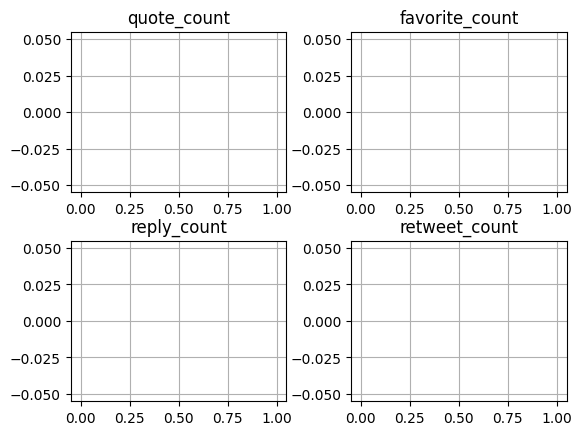

In [18]:
def hist_interaction(df):
    print(df[['quote_count', 'favorite_count', 'reply_count', 'retweet_count']].describe())
    new_df = df[df['retweet_count'] > 50]
    new_df[['quote_count', 'favorite_count', 'reply_count', 'retweet_count']].hist()

hist_interaction(df)

        quote_count  favorite_count   reply_count  retweet_count
count  15719.000000    16031.000000  15718.000000   16031.000000
mean       2.385584       38.920778      1.496246      20.046660
std       59.563735      838.645714     36.767808     460.846986
min        0.000000        0.000000      0.000000       0.000000
25%        0.000000        0.000000      0.000000       0.000000
50%        0.000000        0.000000      0.000000       0.000000
75%        0.000000        0.000000      0.000000       0.000000
max     4010.000000    51726.000000   3797.000000   36840.000000


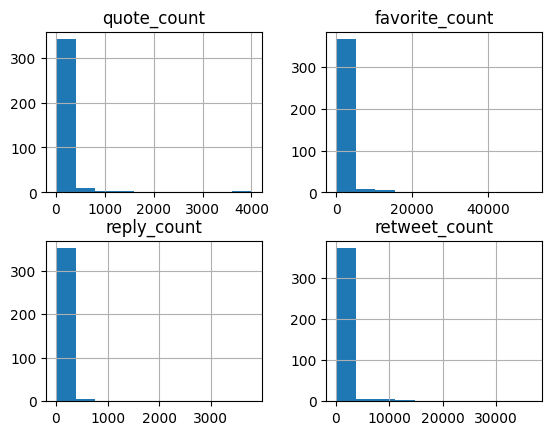

In [72]:
def hist_interaction(df):
    print(df[['quote_count', 'favorite_count', 'reply_count', 'retweet_count']].describe())
    new_df = df[df['retweet_count'] > 50]
    new_df[['quote_count', 'favorite_count', 'reply_count', 'retweet_count']].hist()

hist_interaction(df_con_nan)

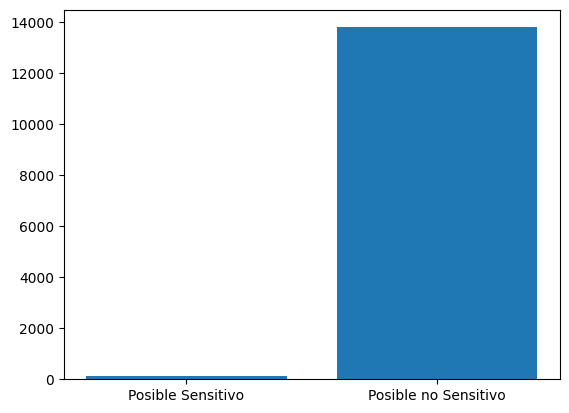

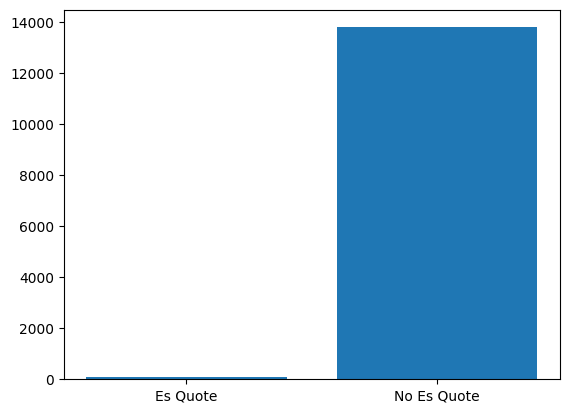

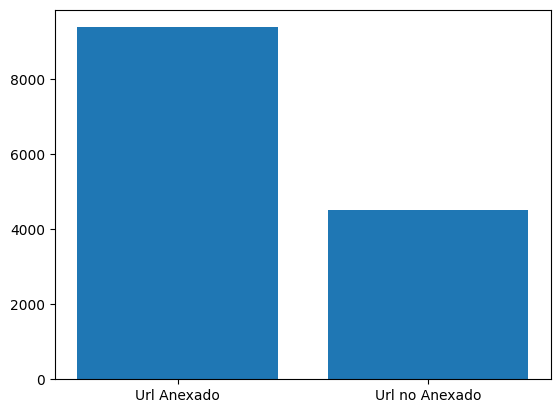

In [73]:
def count_booleans(df):
    valores_T = 0
    valores_F = 0
    quoteable = 0
    not_quotable = 0
    url = 0
    urlnt = 0

    for i in range(df.shape[0]):
        if df["possibly_sensitive"][i]:
            valores_T +=1
        else:
            valores_F +=1

        if df["is_quote_status"][i]:
            quoteable += 1
        else:
            not_quotable += 1        

        if df["entities_urls"][i]:
            url += 1
        else:
            urlnt += 1

    plt.bar(["Posible Sensitivo","Posible no Sensitivo"],[valores_T, valores_F])
    plt.show()

    plt.bar(["Es Quote","No Es Quote"],[quoteable, not_quotable])
    plt.show()

    plt.bar(["Url Anexado","Url no Anexado"],[url, urlnt])
    plt.show()

count_booleans(df)

Se procede a analizar los tweets si son informativos y si son humanitarios. Se separan en grupos según el valor 'conf'. Si 'conf' es 1, se grafican los valores como tal. Si 'conf' es menor a 1, se gráfica junto al promedio de conf.


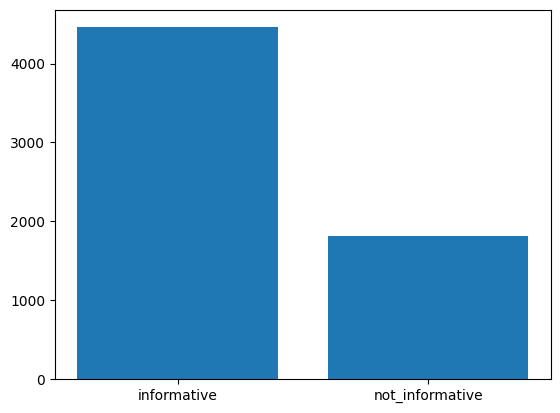

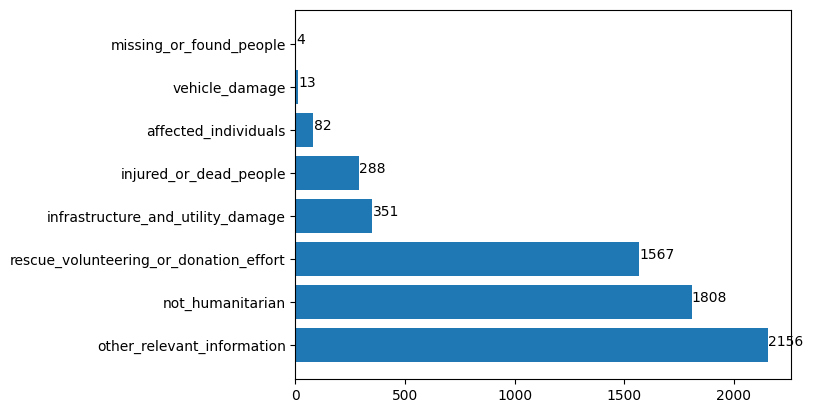

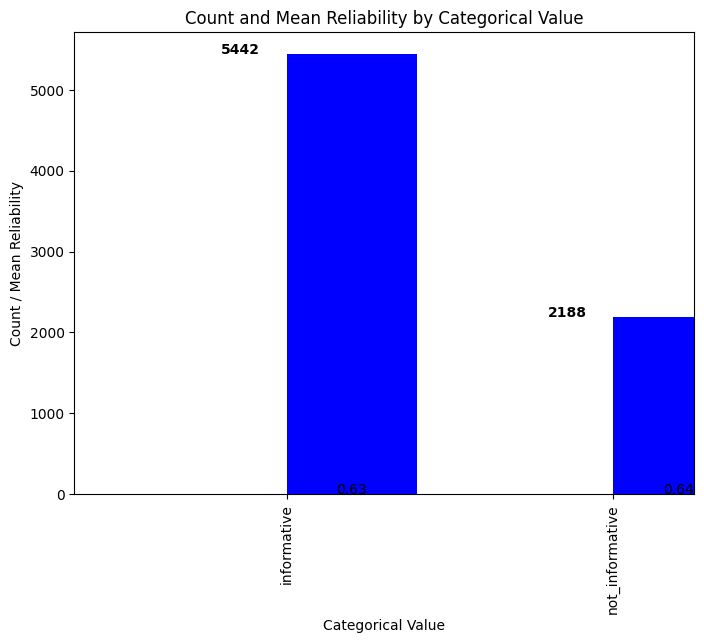

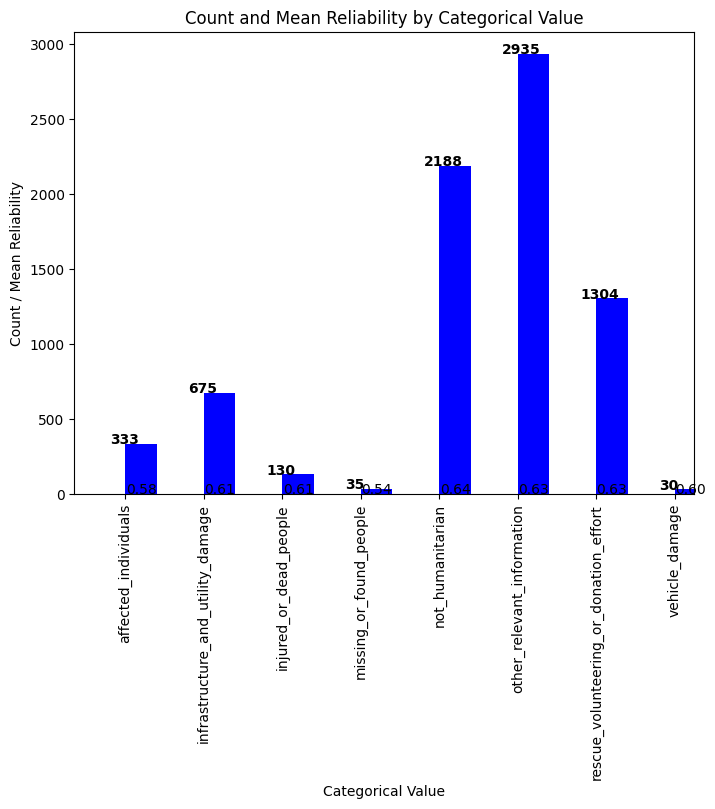

In [74]:
def info_and_human(df):
    
    #se copia la dataframe
    df_info = df.copy()
    df_human = df.copy()

    #se borran los archivos NaN correspondientes
    df_info = df_info[df_info['text_info'].notna()]
    df_info = df_info[df_info['text_info_conf'].notna()]
    df_human = df_human[df_human['text_human'].notna()]
    df_human = df_human[df_human['text_human_conf'].notna()]

    #se reinicia la index si necesario
    df_info.reset_index(inplace=True, drop=True)
    df_human.reset_index(inplace=True, drop=True)

    #se crea nueva id según index
    df_info["new_id"] = df_info.index
    df_human["new_id"] = df_human.index

    
    #se crean dataframes para separar conf=1 con conf<1
    info_confiable = df_info[["new_id", "id", "text_info", "text_info_conf"]].copy()
    info_casi_confiable = df_info[["new_id", "id", "text_info", "text_info_conf"]].copy()

    wanted = []
    not_wanted = []

    i = 0
    while i < info_confiable.shape[0]:
        #print(info_confiable["text_info_conf"][i])
        if info_confiable["text_info_conf"][i] < 1:
            not_wanted.append(info_confiable["new_id"][i])
        else:
            wanted.append(info_confiable["new_id"][i])
        i += 1


    for j in not_wanted:
        info_confiable = info_confiable.drop(info_confiable[info_confiable["new_id"]==j].index)

    for k in wanted:
        info_casi_confiable = info_casi_confiable.drop(info_casi_confiable[info_casi_confiable["new_id"]==k].index)


    #se crean dataframes para separar conf=1 con conf<1
    human_confiable = df_human[["new_id", "id", "text_human", "text_human_conf"]].copy()
    human_casi_confiable = df_human[["new_id", "id", "text_human", "text_human_conf"]].copy()

    hwanted = []
    not_hwanted = []

    i = 0
    while i < human_confiable.shape[0]:
        #print(info_confiable["text_info_conf"][i])
        if human_confiable["text_human_conf"][i] < 1:
            not_hwanted.append(human_confiable["new_id"][i])
        else:
            hwanted.append(human_confiable["new_id"][i])
        i += 1


    for j in not_hwanted:
        human_confiable = human_confiable.drop(human_confiable[human_confiable["new_id"]==j].index)

    for k in hwanted:
        human_casi_confiable = human_casi_confiable.drop(human_casi_confiable[human_casi_confiable["new_id"]==k].index)


    valores_info_confiable = info_confiable["text_info"].value_counts()

    plt.bar(valores_info_confiable.index, valores_info_confiable.values)

    plt.xlabel("")
    plt.ylabel("")
    plt.title("")

    plt.show()

    valores_human_confiable = human_confiable["text_human"].value_counts()

    plt.barh(valores_human_confiable.index, valores_human_confiable.values)

    for i, v in enumerate(valores_human_confiable.values):
        plt.text(v + 1, i, str(v))

    plt.xlabel("")
    plt.ylabel("")
    plt.title("")

    #plt.xticks(rotation=90)

    plt.show()


    # calculate counts and means
    counts = info_casi_confiable['text_info'].value_counts().sort_index()
    means = info_casi_confiable.groupby('text_info')['text_info_conf'].mean().sort_index()

    # plot the bar chart
    fig, ax = plt.subplots(figsize=(8,6))
    counts.plot(kind='bar', color='blue', width=0.4, position=0, ax=ax)
    means.plot(kind='bar', color='red', width=0.4, position=1, ax=ax)

    # add labels
    ax.set_xlabel('Categorical Value')
    ax.set_ylabel('Count / Mean Reliability')
    ax.set_title('Count and Mean Reliability by Categorical Value')

    # add value labels
    for i, count in enumerate(counts):
        ax.text(i-0.2, count+0.1, str(count), color='black', fontweight='bold')
    for i, mean in enumerate(means):
        ax.text(i+0.2, mean+0.02, f'{mean:.2f}', color='black', ha='center')

    # calculate counts and means
    counts = human_casi_confiable['text_human'].value_counts().sort_index()
    means = human_casi_confiable.groupby('text_human')['text_human_conf'].mean().sort_index()

    # plot the bar chart
    fig, ax = plt.subplots(figsize=(8,6))
    counts.plot(kind='bar', color='blue', width=0.4, position=0, ax=ax)
    means.plot(kind='bar', color='red', width=0.4, position=1, ax=ax)

    # add labels
    ax.set_xlabel('Categorical Value')
    ax.set_ylabel('Count / Mean Reliability')
    ax.set_title('Count and Mean Reliability by Categorical Value')

    # add value labels
    for i, count in enumerate(counts):
        ax.text(i-0.2, count+0.1, str(count), color='black', fontweight='bold')
    for i, mean in enumerate(means):
        ax.text(i+0.2, mean+0.02, f'{mean:.2f}', color='black', ha='center')

info_and_human(df)

#### Conteo de palabras

In [75]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

text_data = df['text'].str.split().tolist()
all_words = [word.lower() for sublist in text_data for word in sublist]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aguti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aguti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
stopwords_en = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word not in stopwords_en]
word_counter = Counter(filtered_words)
top_words = word_counter.most_common(90)  # Puedes ajustar el número de palabras que deseas mostrar


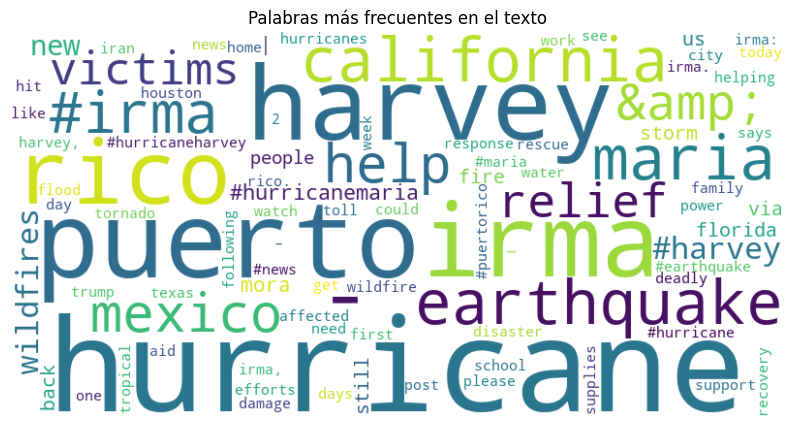

In [77]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_words))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras más frecuentes en el texto')
plt.show()


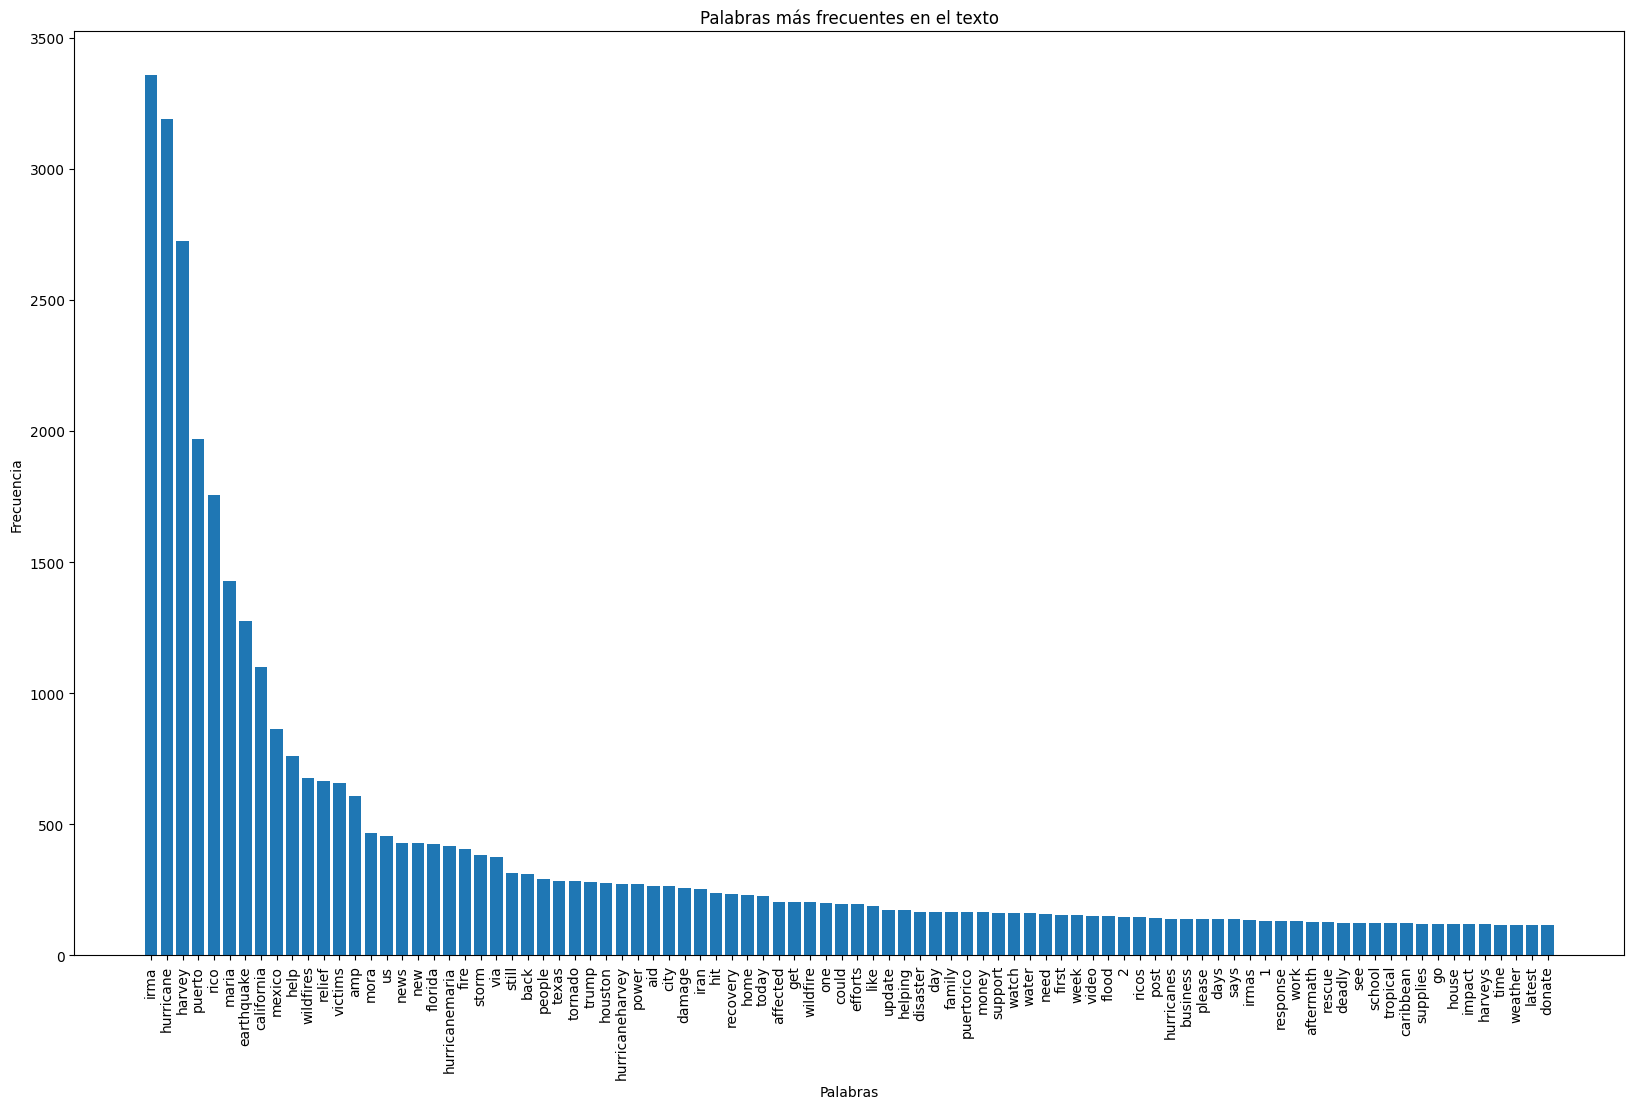

In [78]:

# Obtener las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Función para limpiar y tokenizar el texto
def clean_and_tokenize(text):
    # Quitar caracteres especiales y símbolos "#" pegados a las palabras
    text = re.sub(r'[^\w\s]|#(?=\w)', '', text)
    # Tokenizar el texto en palabras
    tokens = word_tokenize(text.lower())
    # Quitar las stopwords
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Obtener las palabras y sus frecuencias en la columna "text"
words = df['text'].apply(clean_and_tokenize).explode()
word_counts = Counter(words)

# Obtener las palabras más frecuentes
top_words = word_counts.most_common(90)

# Crear el gráfico de barras
plt.figure(figsize=(20,12))
plt.bar(*zip(*top_words))
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes en el texto')
plt.xticks(rotation=90)
plt.show()


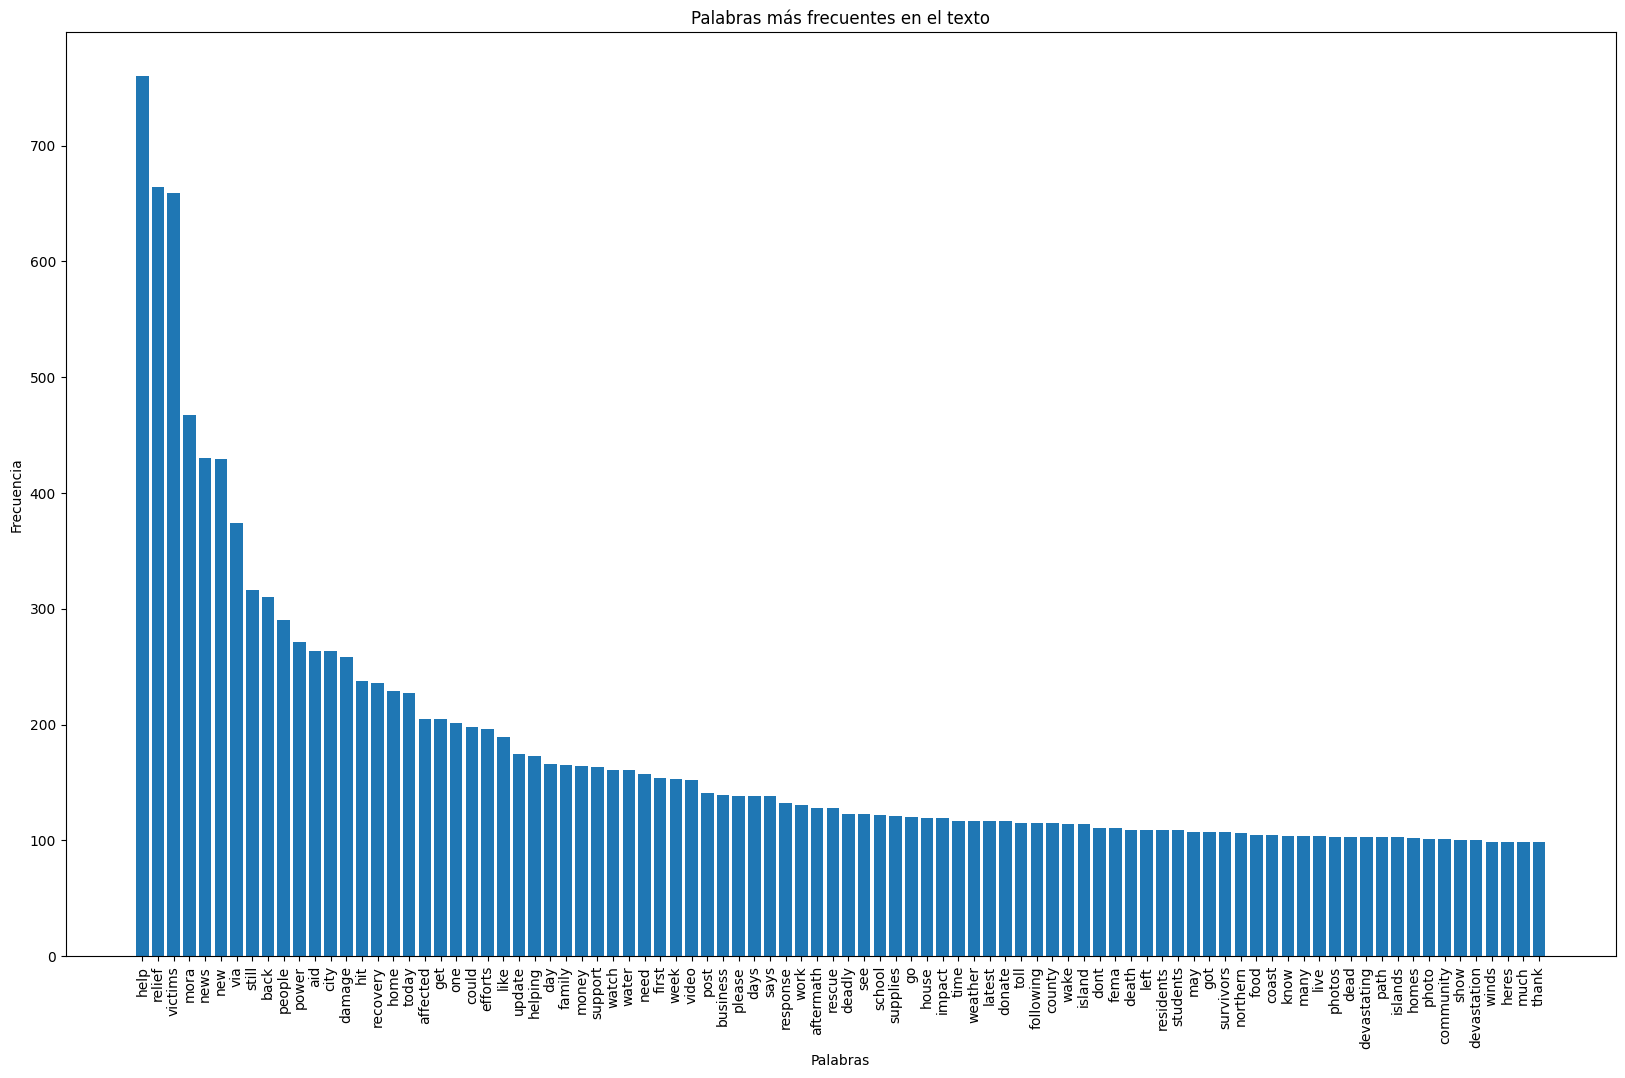

In [26]:

def clean_and_tokenize2(text):
    # Eliminar caracteres especiales y hashtags pegados a palabras
    cleaned_text = re.sub(r"[^\w\s]|(#\w+)", "", text)

    # Tokenizar el texto
    tokens = word_tokenize(cleaned_text.lower())

    # Eliminar stopwords en inglés y palabras adicionales
    stop_words = set(stopwords.words('english'))
    additional_stop_words = ['california', 'wildfires', 'hurricane', 'harvey', 'irma', 'maria', 'iraq', 
     'iran', 'earthquake', 'mexico', 'srilanka', 'floods','puerto','rico','us','texas','florida','texas','hurricanemaria',
     'hurricaneharvey','puertorico','mexicoearthquake','houston','wildfire','ricos','tornado' , 'storm','flood','fire','trump',
     'hurricanes','caribbean','flooding','disaster','irmas','tropical','harveys','st','amp']
    stop_words.update(additional_stop_words)

    # Agregar números a la lista de stopwords
    stop_words.update(additional_stop_words)
    stop_words.update(set(token for token in tokens if token.isdigit()))

    # Filtrar las palabras
    filtered_tokens = [token for token in tokens if token not in stop_words]

    return filtered_tokens

# Obtener las palabras y sus frecuencias en la columna "text"
words = df['text'].apply(clean_and_tokenize2).explode()
word_counts = Counter(words)

# Obtener las palabras más frecuentes
top_words = word_counts.most_common(90)

# Crear el gráfico de barras
plt.figure(figsize=(20,12))
plt.bar(*zip(*top_words))
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes en el texto')
plt.xticks(rotation=90)
plt.show()

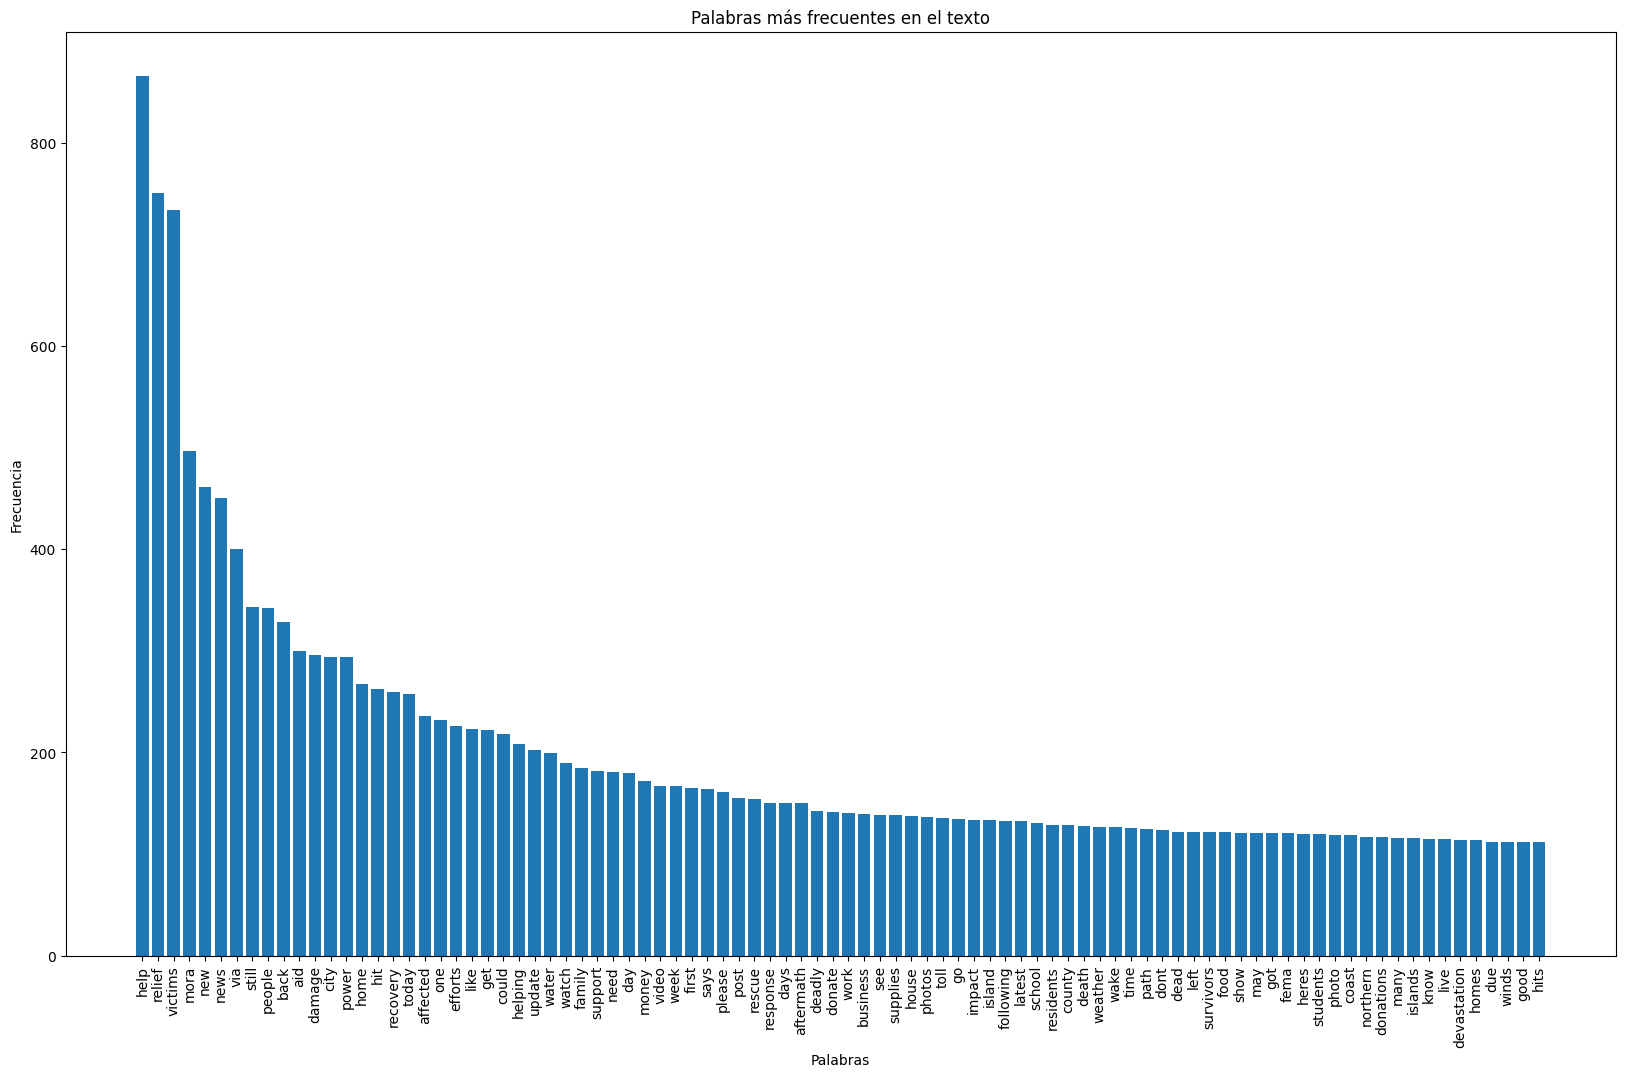

In [27]:
# Obtener las palabras y sus frecuencias en la columna "text"
words = df_con_nan['text'].apply(clean_and_tokenize2).explode()
word_counts = Counter(words)

# Obtener las palabras más frecuentes
top_words = word_counts.most_common(90)

# Crear el gráfico de barras
plt.figure(figsize=(20,12))
plt.bar(*zip(*top_words))
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes en el texto')
plt.xticks(rotation=90)
plt.show()

#### Conteo de palabra text human

In [28]:
a=df[df["text_human"] == 'affected_individuals']


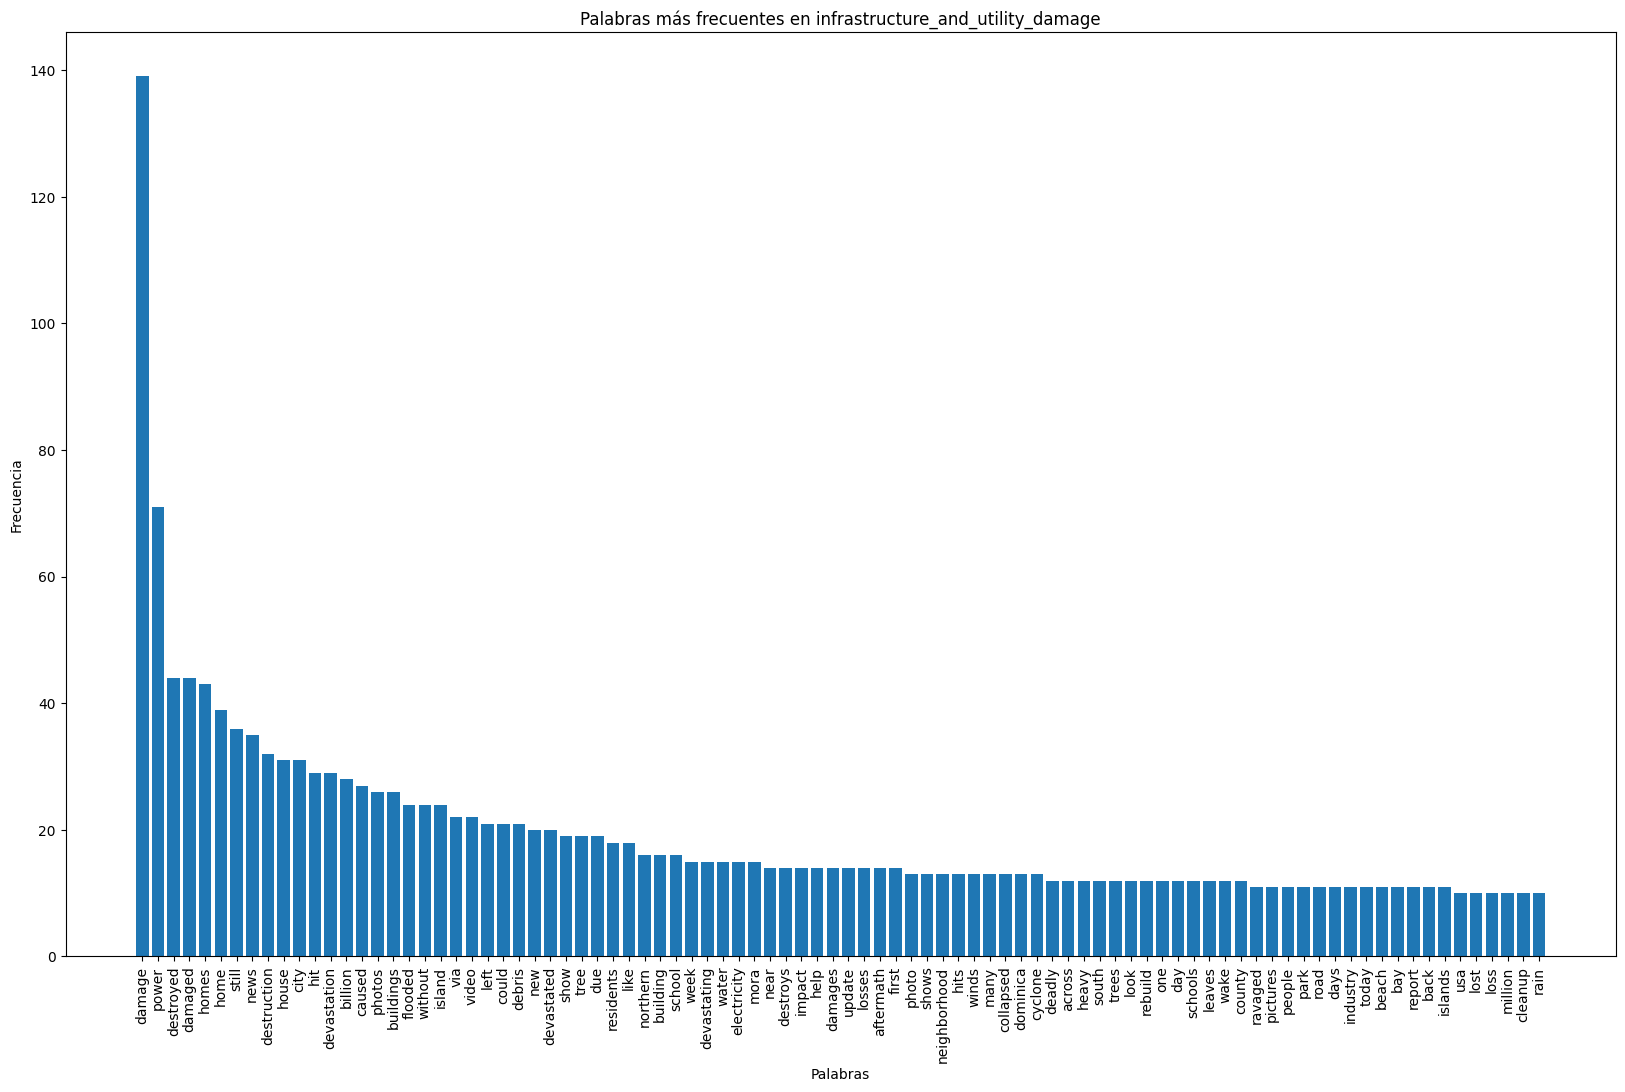

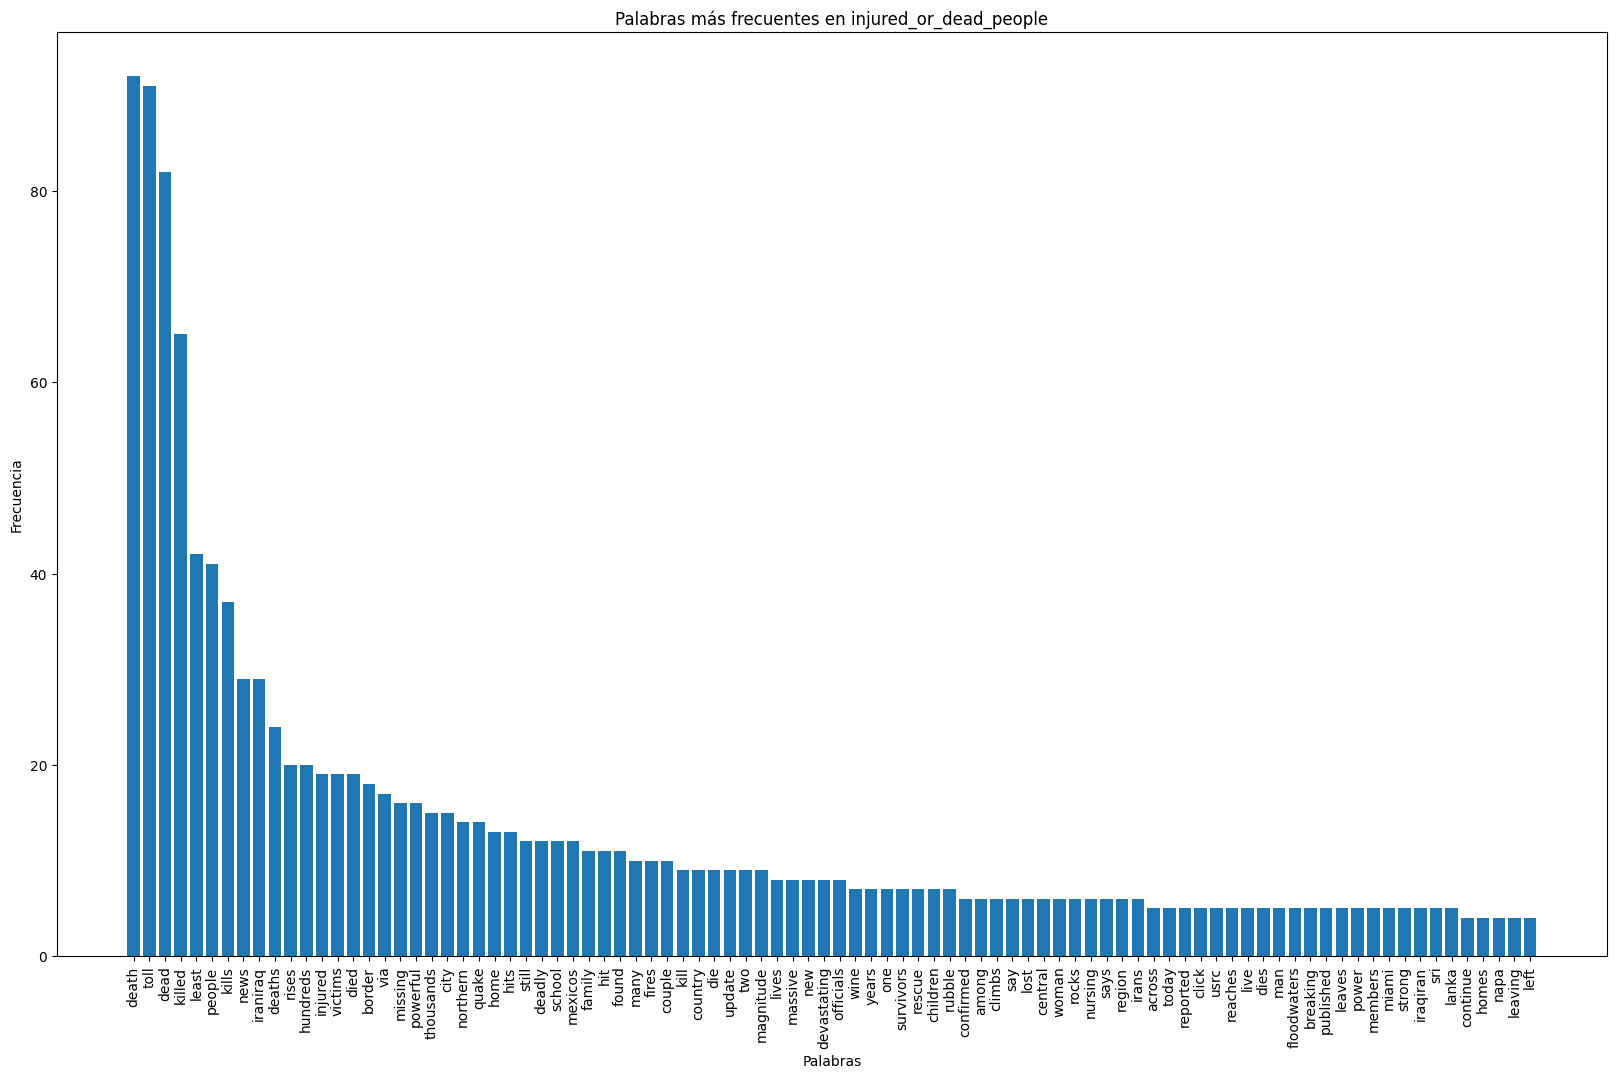

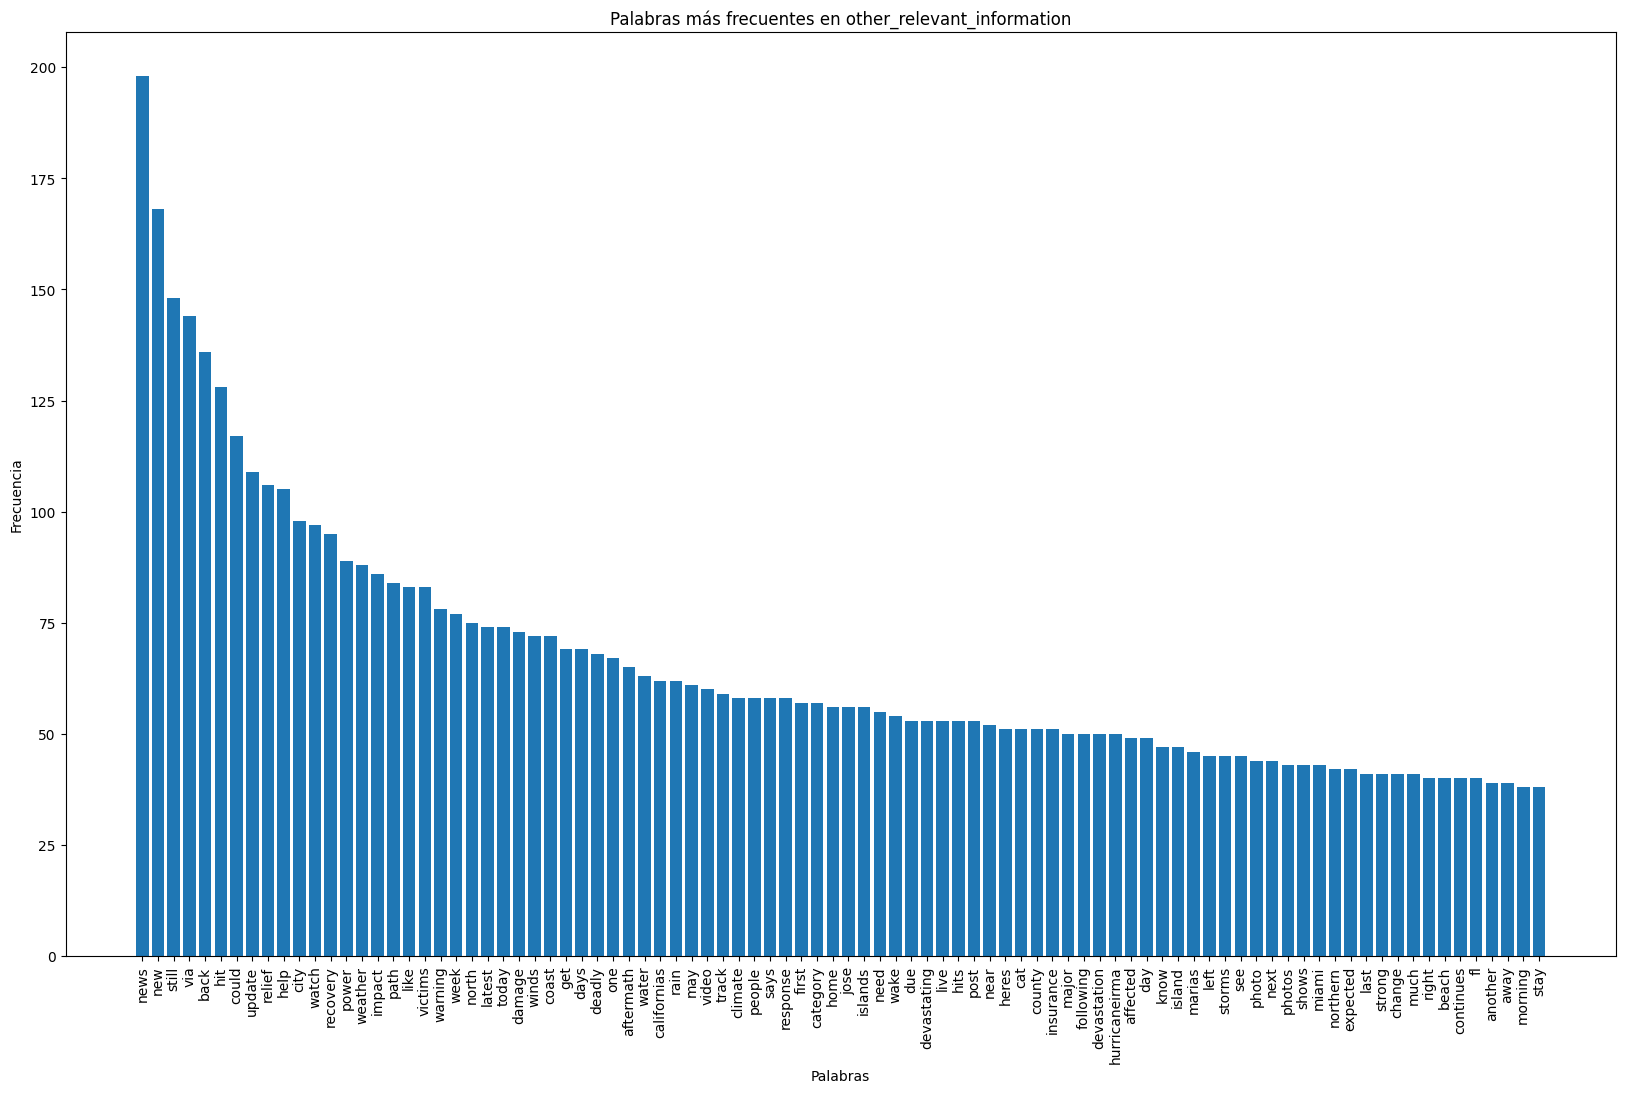

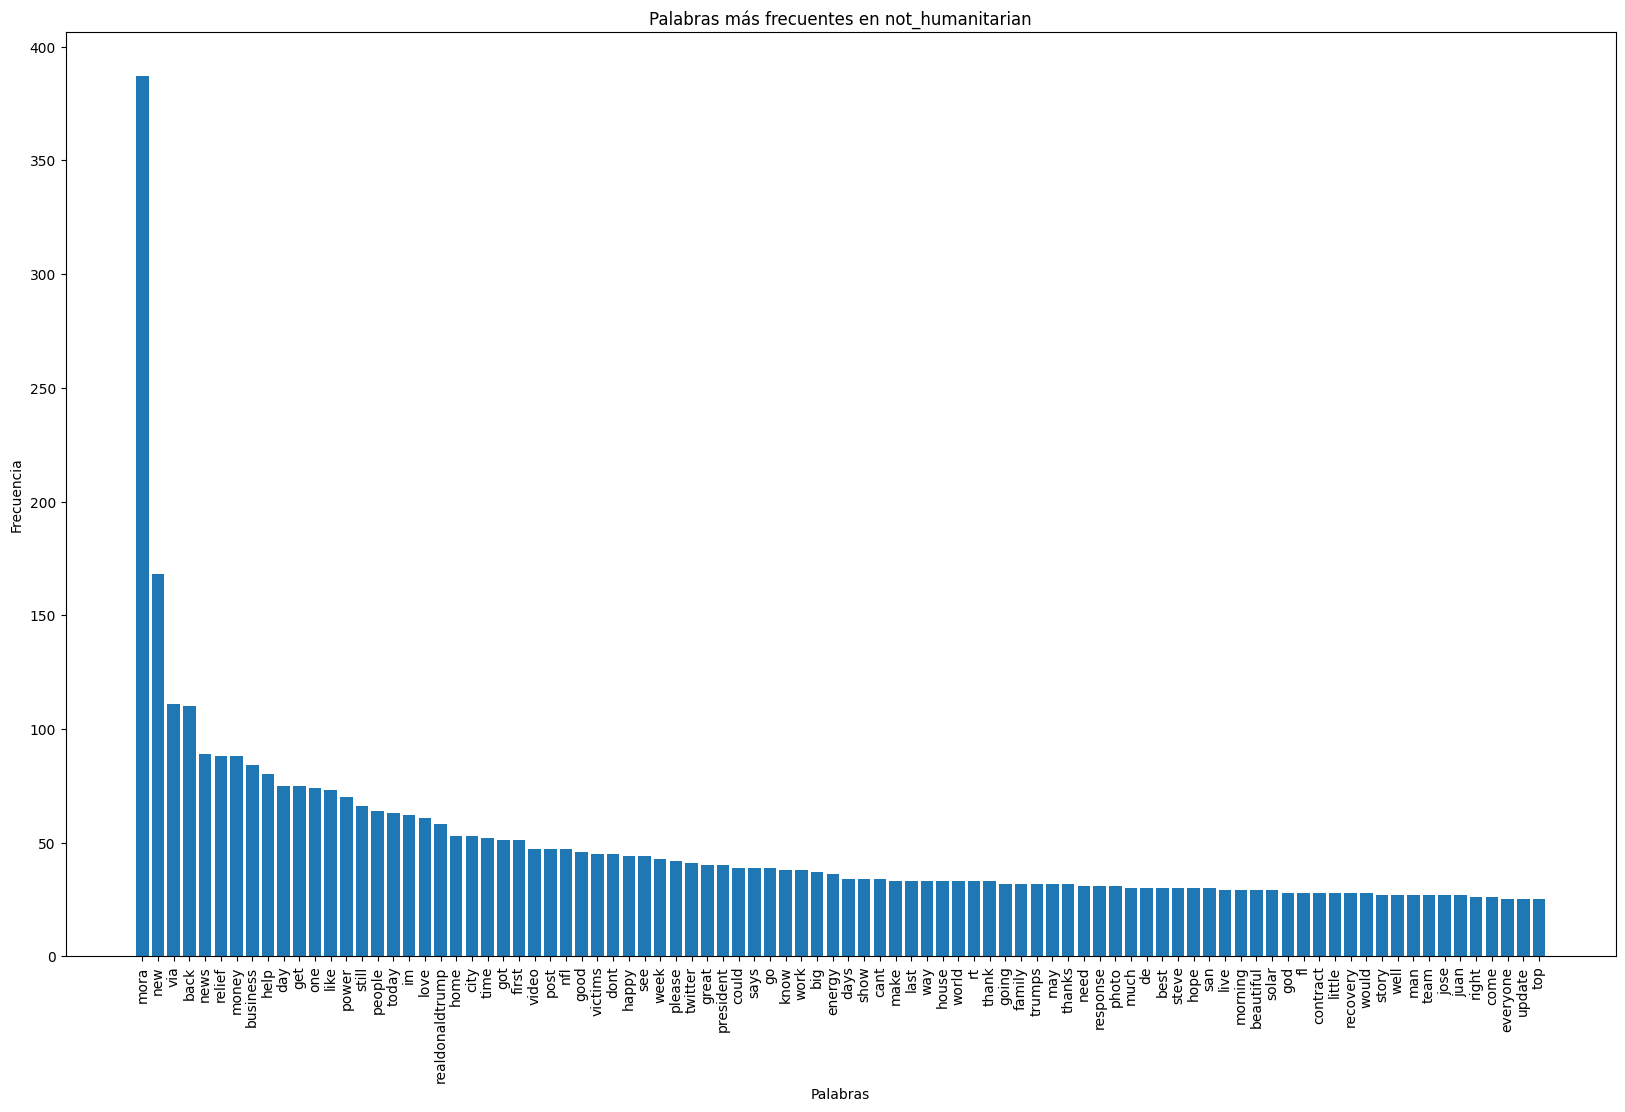

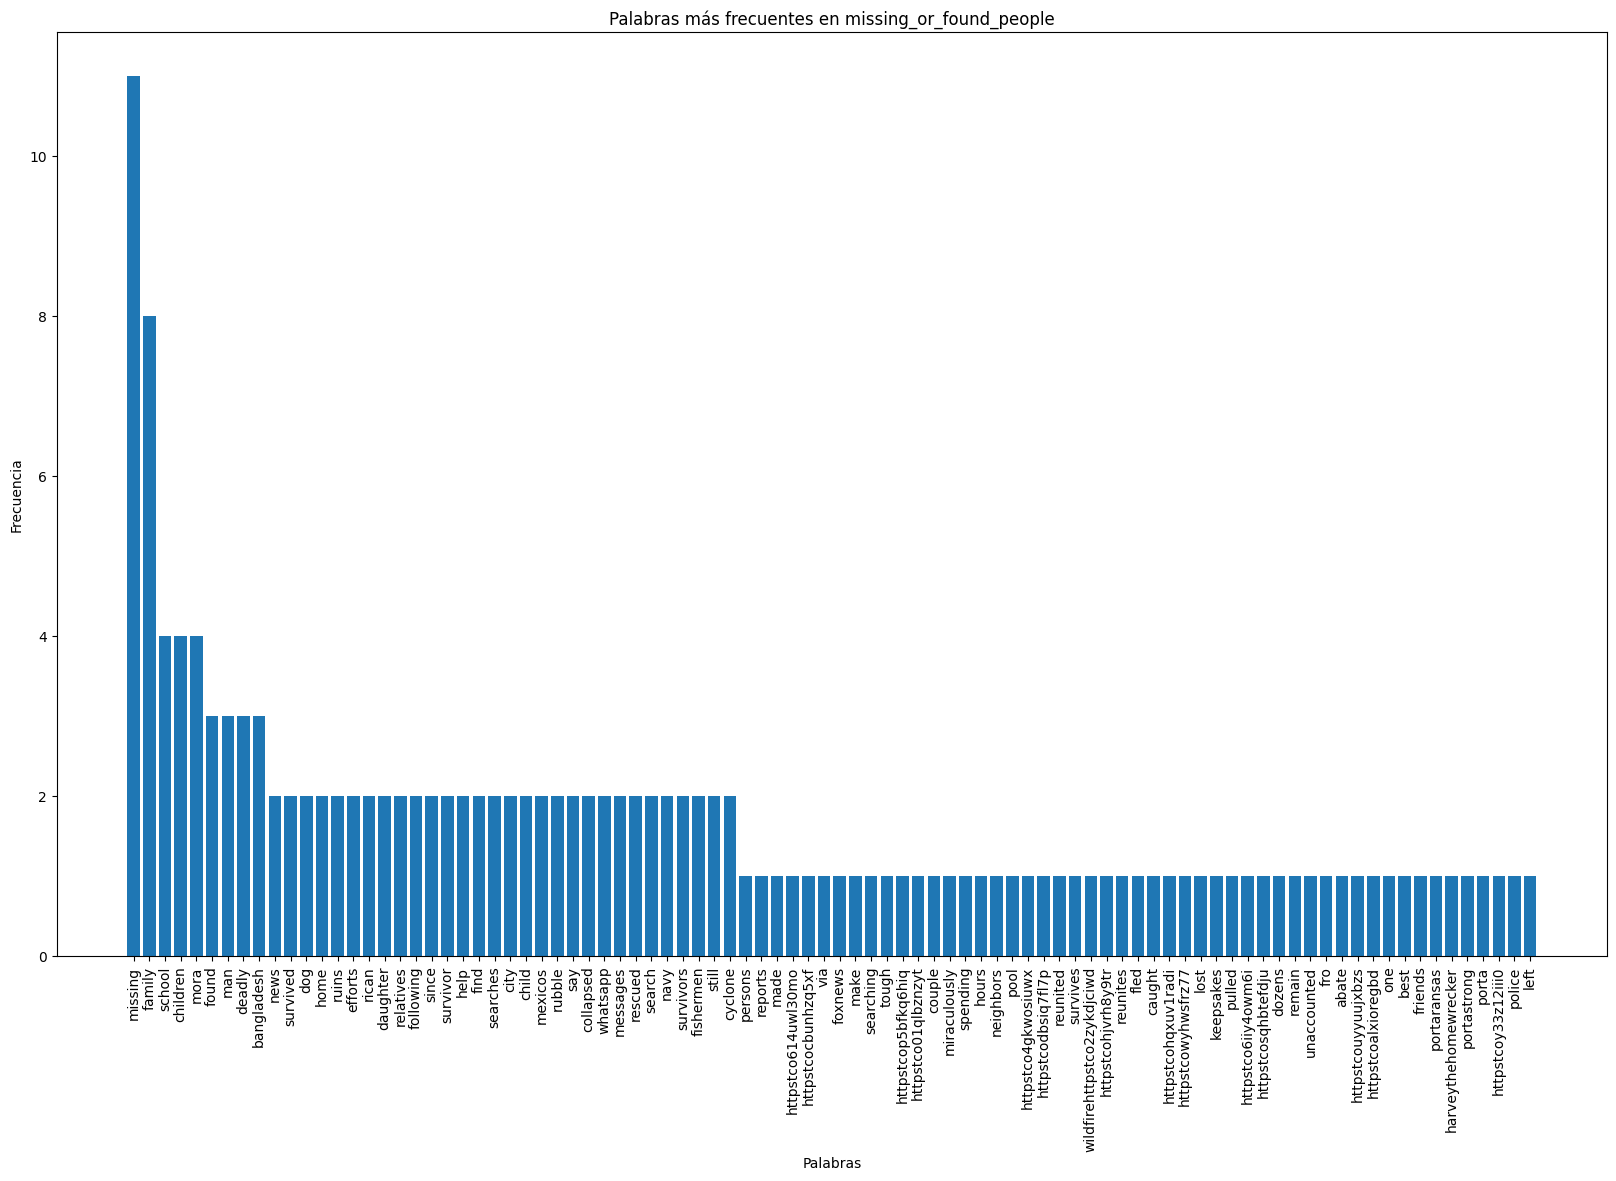

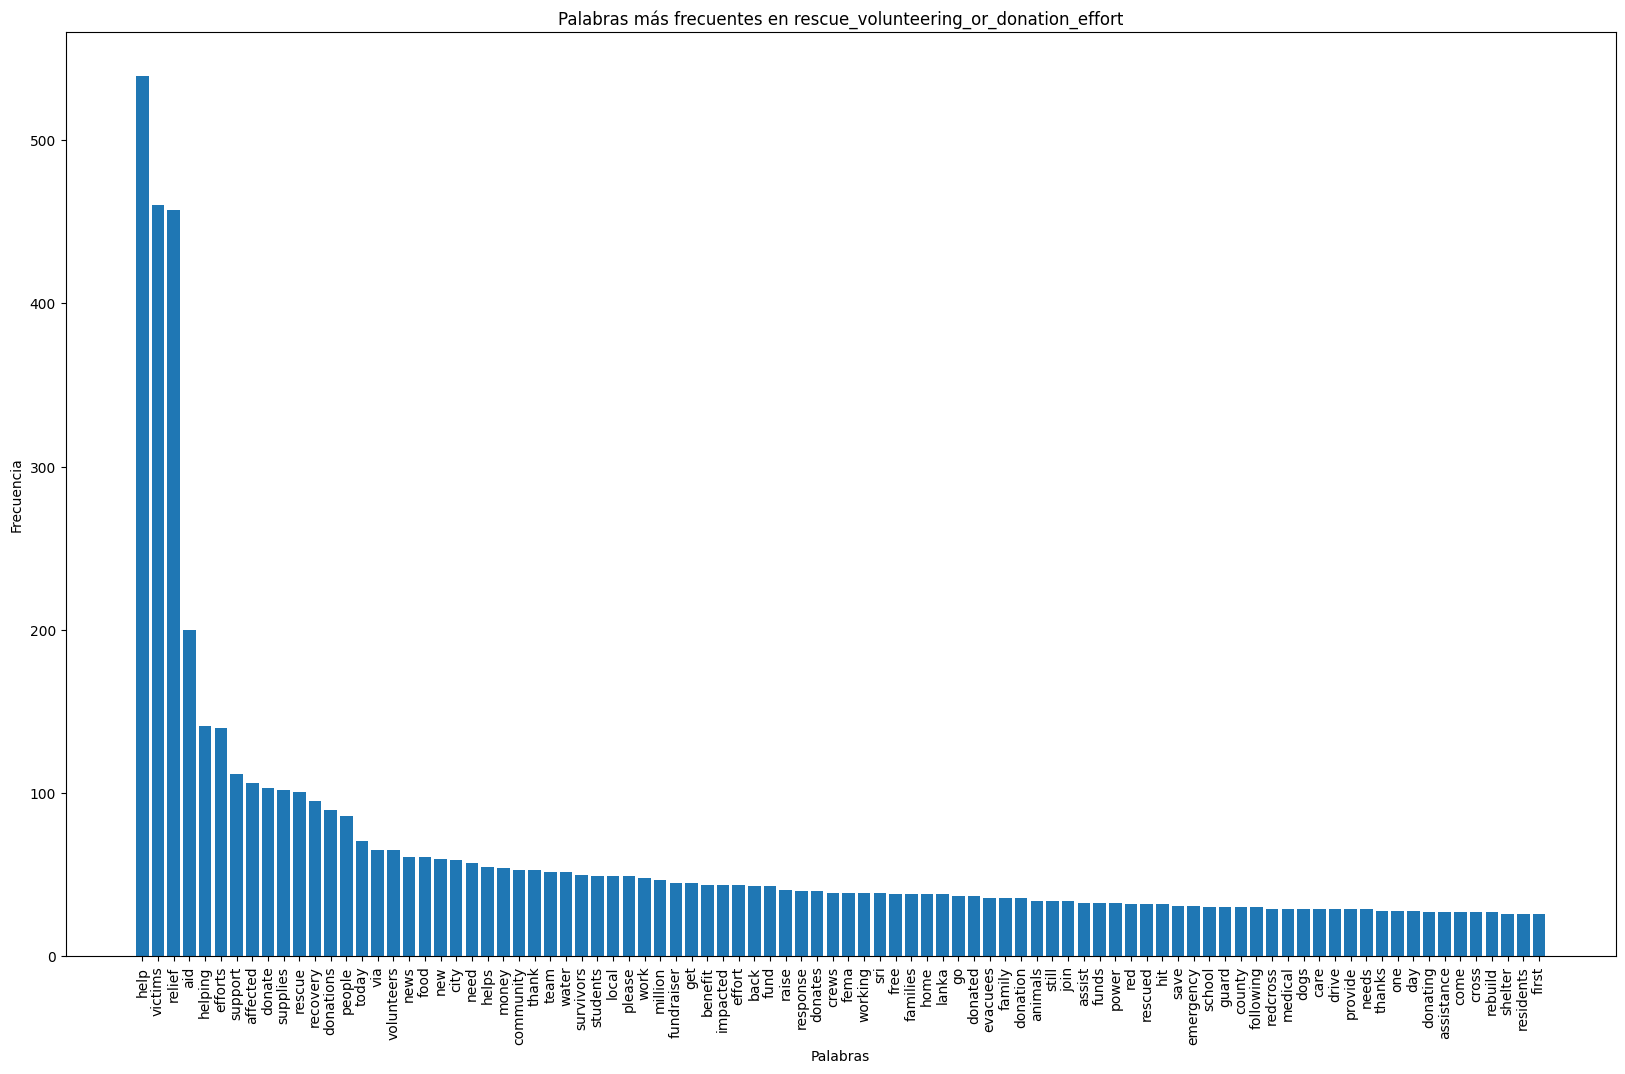

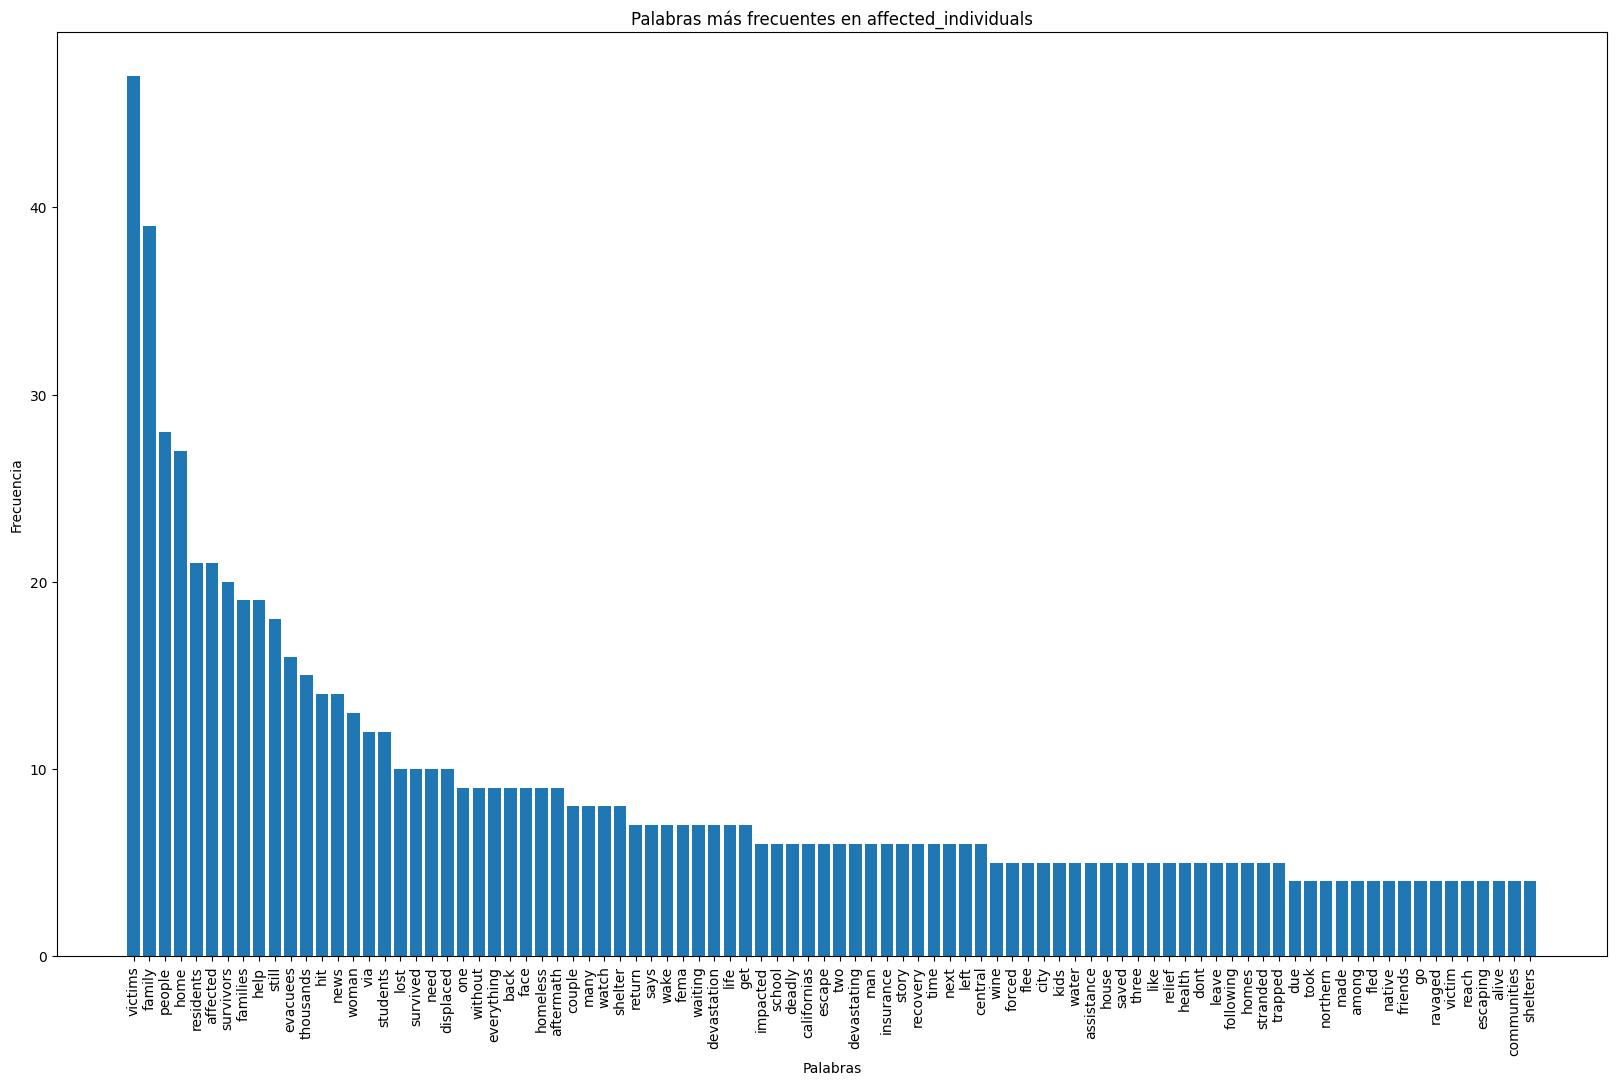

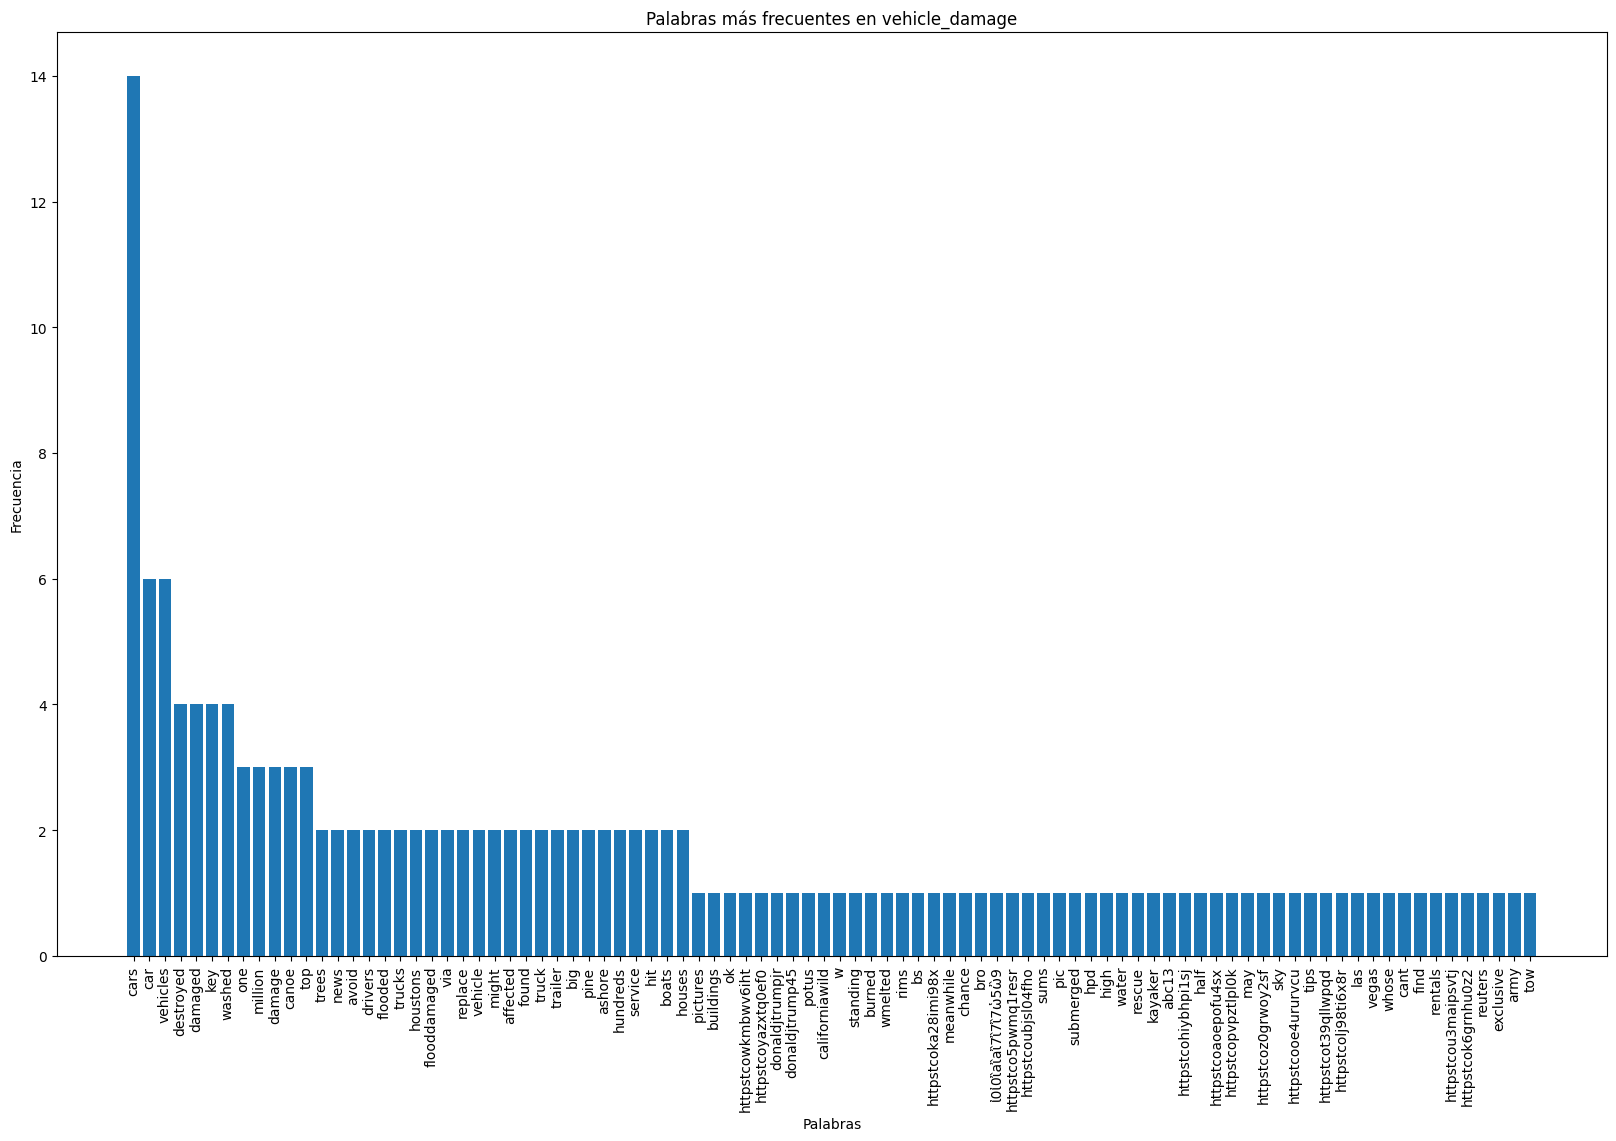

In [29]:
def conteo_por_text_human(df):
    text_human_list = df['text_human'].unique().tolist()
    for text_human in text_human_list:
        a=df[df["text_human"] == text_human]
        words1 = a['text'].apply(clean_and_tokenize2).explode()
        word_counts1 = Counter(words1)
        top_words = word_counts1.most_common(90)
        # crear el gráfico de barras
        plt.figure(figsize=(20,12))
        plt.bar(*zip(*top_words))
        plt.xlabel('Palabras')
        plt.ylabel('Frecuencia')
        plt.title(f'Palabras más frecuentes en {text_human}')
        plt.xticks(rotation=90)
        plt.show()

conteo_por_text_human(df)

### Embeddings

In [31]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopword_tokens
import numpy as np


# Supongamos que tienes una lista de oraciones en la columna de texto
sentences = df["text"].tolist()

stop_words = set(stopwords.words('english'))
additional_stop_words = ['california', 'wildfires', 'hurricane', 'harvey', 'irma', 'maria', 'iraq', 
     'iran', 'earthquake', 'mexico', 'srilanka', 'floods','puerto','rico','us','texas','florida','texas','hurricanemaria',
     'hurricaneharvey','puertorico','mexicoearthquake','houston','wildfire','ricos','tornado' , 'storm','flood','fire','trump',
     'hurricanes','caribbean','flooding','disaster','irmas','tropical','harveys','st']
stop_words.update(additional_stop_words)

# Tokeniza las oraciones y crea una lista de listas de palabras
#tokenized_sentences = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in sentences]


# Definir los parámetros del modelo Word2Vec
vector_size = 100  # Dimensión del espacio vectorial
window_size = 5  # Tamaño de la ventana de contexto
min_count = 1  # Frecuencia mínima de las palabras para ser consideradas

def cargar_embeddings_glove(ruta_archivo):
    embeddings_index = {}
    with open(ruta_archivo, encoding='utf-8') as archivo:
        for linea in archivo:
            valores = linea.split()
            palabra = valores[0]
            vector = np.asarray(valores[1:], dtype='float32')
            embeddings_index[palabra] = vector
    return embeddings_index

ruta_archivo_glove = "D:\Programación\Semestre 10\Mineria\Repo\Glove\glove.6B.200d.txt"  # Reemplaza con la ruta real de tu archivo GloVe
embeddings_glove = cargar_embeddings_glove(ruta_archivo_glove)

# Crear y entrenar el modelo
#model = Word2Vec(tokenized_sentences, vector_size=vector_size, window=window_size, min_count=min_count)

# Obtén el vector de una palabra específica
# word = "help"
# vector = model.wv[word]
# print(f"Vector de '{word}': {vector}")

# Encuentra palabras similares a una palabra dada
# similar_words = model.wv.most_similar(word)
# print(f"Palabras similares a '{word}': {similar_words}")



In [32]:
from sklearn.model_selection import train_test_split

# Carga el dataset en un DataFrame de pandas

# Divide los datos en características (X) y etiquetas (y)
X = df['text'].values  # Reemplaza 'columna_de_texto' con el nombre real de tu columna
y = df['text_human'].values  # Reemplaza 'columna_etiquetas' con el nombre real de tu columna de etiquetas

#### clasificacion entre humanitario y no humanitario

In [102]:
y_bin = y.copy()
for i in range( len(y_bin)):
    if (y_bin[i] != 'not_humanitarian'):
        y_bin[i] = 'humanitarian'

In [107]:
# Divide los datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

In [108]:
from gensim.utils import simple_preprocess
from spacy.lang.en.stop_words import STOP_WORDS
import numpy as np

stop_words = STOP_WORDS
additional_stop_words = ['california', 'wildfires', 'hurricane', 'harvey', 'irma', 'maria', 'iraq', 
     'iran', 'earthquake', 'mexico', 'srilanka', 'floods','puerto','rico','us','texas','florida','texas','hurricanemaria',
     'hurricaneharvey','puertorico','mexicoearthquake','houston','wildfire','ricos','tornado' , 'storm','flood','fire','trump',
     'hurricanes','caribbean','flooding','disaster','irmas','tropical','harveys','st']
stop_words.update(additional_stop_words)

tokenized_sentences_train = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_train]
tokenized_sentences_test = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_test]

# vectors_train = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_train]
# vectors_test = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_test]

vectors_train = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_train]
vectors_test = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_test]


def average_vectors(vectors):
    averaged_vectors = []
    for sentence_vectors in vectors:
        if len(sentence_vectors) > 0:
            averaged_vectors.append(np.mean(sentence_vectors, axis=0))
        else:
            averaged_vectors.append(np.zeros(200))
    return averaged_vectors

X_train_embeddings = average_vectors(vectors_train)
X_test_embeddings = average_vectors(vectors_test)


### Linear SVC

In [109]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()
classifier.fit(X_train_embeddings, y_train)

y_pred = classifier.predict(X_test_embeddings)


In [110]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred,average='macro')
f1 = f1_score(y_test, y_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



Accuracy: 0.7762589928057554
Precision: 0.7468519333376813
Recall: 0.6838610064250494
F1 Score: 0.6999442631666989


#### Clasificación rescue_volunteering vs human and material losses (con others incluído)

In [111]:
df_humanitarian = df[df['text_human'] != 'not_humanitarian']
x_humanitarian = df_humanitarian['text'].values
y_humanitarian = df_humanitarian['text_human'].values

In [112]:
y_bin_human = y_humanitarian.copy()
for i in range( len(y_bin_human)):
    if (y_bin_human[i] != 'rescue_volunteering_or_donation_effort'):
        y_bin_human[i] = 'human_and_material_losses'

In [116]:
X_human_train, X_human_test, y_human_train, y_human_test = train_test_split(x_humanitarian, y_bin_human, test_size=0.2, random_state=42)

In [117]:
tokenized_sentences_train = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_human_train]
tokenized_sentences_test = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_human_test]

# vectors_train = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_train]
# vectors_test = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_test]

vectors_train = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_train]
vectors_test = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_test]


def average_vectors(vectors):
    averaged_vectors = []
    for sentence_vectors in vectors:
        if len(sentence_vectors) > 0:
            averaged_vectors.append(np.mean(sentence_vectors, axis=0))
        else:
            averaged_vectors.append(np.zeros(200))
    return averaged_vectors

X_train_embeddings = average_vectors(vectors_train)
X_test_embeddings = average_vectors(vectors_test)

In [118]:
classifier = LinearSVC()
classifier.fit(X_train_embeddings, y_human_train)

y_human_pred = classifier.predict(X_test_embeddings)

In [119]:
accuracy = accuracy_score(y_human_test, y_human_pred)
precision = precision_score(y_human_test, y_human_pred,average='macro')
recall = recall_score(y_human_test, y_human_pred,average='macro')
f1 = f1_score(y_human_test, y_human_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8707723372034326
Precision: 0.8382470006657319
Recall: 0.8166935883867922
F1 Score: 0.8264635431637444


#### Clasificación rescue_volunteering vs human and material losses vs others

In [120]:
y_tri = y_humanitarian.copy()
for i in range( len(y_tri)):
    if (y_tri[i] != 'other_relevant_information' and y_tri[i] != 'rescue_volunteering_or_donation_effort'):
        y_tri[i] = 'human_and_material_losses'

In [123]:
X_tri_train, X_tri_test, y_tri_train, y_tri_test = train_test_split(x_humanitarian, y_tri, test_size=0.2, random_state=42)

In [124]:
tokenized_sentences_train = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_tri_train]
tokenized_sentences_test = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_tri_test]

# vectors_train = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_train]
# vectors_test = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_test]

vectors_train = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_train]
vectors_test = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_test]


def average_vectors(vectors):
    averaged_vectors = []
    for sentence_vectors in vectors:
        if len(sentence_vectors) > 0:
            averaged_vectors.append(np.mean(sentence_vectors, axis=0))
        else:
            averaged_vectors.append(np.zeros(200))
    return averaged_vectors

X_train_embeddings = average_vectors(vectors_train)
X_test_embeddings = average_vectors(vectors_test)

In [126]:
classifier = LinearSVC()
classifier.fit(X_train_embeddings, y_tri_train)

y_tri_pred = classifier.predict(X_test_embeddings)

In [127]:
accuracy = accuracy_score(y_tri_test, y_tri_pred)
precision = precision_score(y_tri_test, y_tri_pred,average='macro')
recall = recall_score(y_tri_test, y_tri_pred,average='macro')
f1 = f1_score(y_tri_test, y_tri_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7481070166582534
Precision: 0.7326124370665673
Recall: 0.6903355347926231
F1 Score: 0.7037531685281576


In [100]:
text = df_con_nan[df_con_nan["id"]==907017142486401024]["text"].tolist()[0]
text = "There was a female unit of NDRF which was sent to Turkey in search & rescue mission when they suffered from earthquake. These same women would have done the same job is they were deployed where the incident happened. That's what every NDRF person does. Just for your information."
print(text)
tokenize_text = remove_stopword_tokens(simple_preprocess(text))
print(tokenize_text)
vectors = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in tokenize_text]]
embeddings = average_vectors(vectors)
l = classifier.predict(embeddings)
print(l[0])

There was a female unit of NDRF which was sent to Turkey in search & rescue mission when they suffered from earthquake. These same women would have done the same job is they were deployed where the incident happened. That's what every NDRF person does. Just for your information.
['female', 'unit', 'ndrf', 'sent', 'turkey', 'search', 'rescue', 'mission', 'suffered', 'earthquake', 'women', 'job', 'deployed', 'incident', 'happened', 'ndrf', 'person', 'information']
humanitarian


### Model 2

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

classifier = Pipeline([
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=1e5)),
               ])
classifier.fit(X_train_embeddings, y_train)

y_pred = classifier.predict(X_test_embeddings)

C:\Users\aguti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred,average='macro')
f1 = f1_score(y_test, y_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.6280575539568345
Precision: 0.5295354482441565
Recall: 0.45110760985547854
F1 Score: 0.477060434691529


### Model 3

In [39]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier 
from sklearn.pipeline import Pipeline

classifier = Pipeline([
                ('tfidf', TfidfTransformer()),
                ("sgd", SGDClassifier(loss="hinge", alpha=0.00001)),
               ])
classifier.fit(X_train_embeddings, y_train)

y_pred = classifier.predict(X_test_embeddings)

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred,average='macro')
f1 = f1_score(y_test, y_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.6201438848920864
Precision: 0.485938534946185
Recall: 0.41118218463112916
F1 Score: 0.42171557293445644


### model 4


### Analisis de intertacciones

#### leer un json (funcion para debug)

In [41]:
top_favoritos = df_con_nan.sort_values(by=["favorite_count"],ascending=False)
#top_favoritos.head(1)
id = top_favoritos.iloc[4]['id']
print(id)
df_json[df_json["id"]==id]
file_path = "RDATA/CrisisMMD_v2.0/json/hurricane_irma_final_data.json"
datos_json = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        if 'retweeted_status' in data and data['retweeted_status'] != None:
            data = data['retweeted_status']
        datos_json.append(data)

df_old_json = pd.DataFrame(datos_json)
diccionario = df_old_json.iloc[df_old_json.loc[df_old_json['id']==id].index]['extended_entities']

diccionario2 = df_old_json.loc[df_old_json['id']==id,"extended_entities"].tolist()
print(diccionario2)


907017142486401024
[{'media': [{'sizes': {'small': {'w': 680, 'resize': 'fit', 'h': 680}, 'thumb': {'w': 150, 'resize': 'crop', 'h': 150}, 'large': {'w': 742, 'resize': 'fit', 'h': 742}, 'medium': {'w': 742, 'resize': 'fit', 'h': 742}}, 'id': 907017136119468033, 'media_url_https': 'https://pbs.twimg.com/media/DJZfR5uX0AEckgi.jpg', 'media_url': 'http://pbs.twimg.com/media/DJZfR5uX0AEckgi.jpg', 'expanded_url': 'https://twitter.com/basedpaco/status/907017142486401024/photo/1', 'indices': [28, 51], 'id_str': '907017136119468033', 'type': 'photo', 'display_url': 'pic.twitter.com/HHDkPOTruk', 'url': 'https://t.co/HHDkPOTruk'}]}]


#### Grafico de cantidad de tweets por fechas

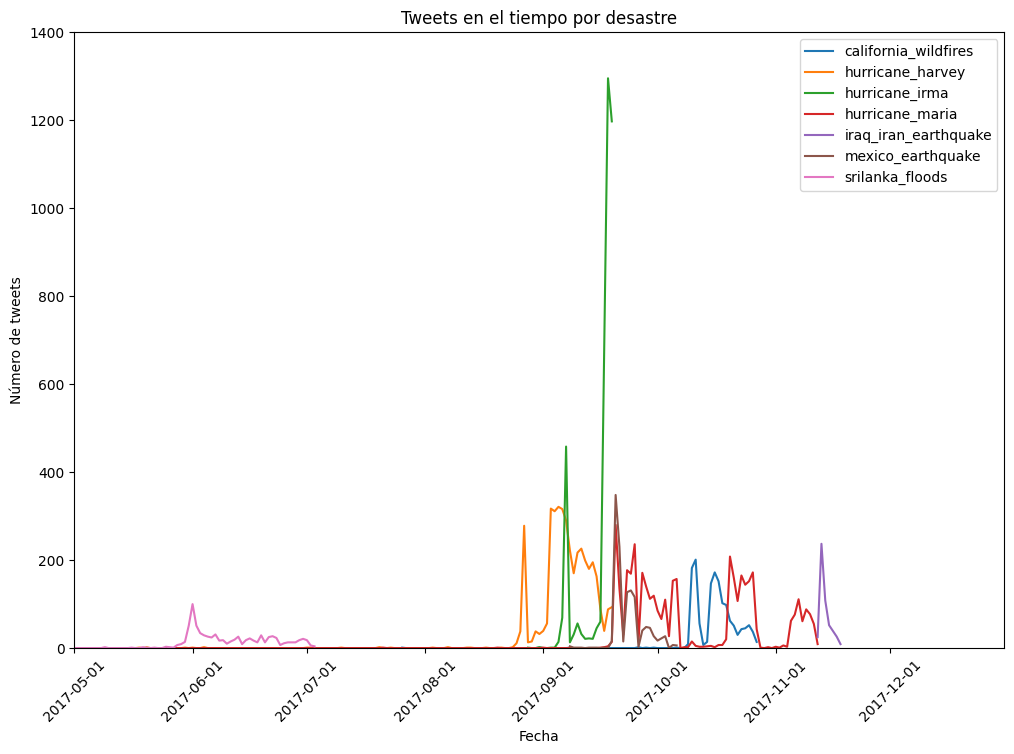

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Convertir la columna 'created_at' a un objeto de fecha y hora
df_con_nan['created_at'] = pd.to_datetime(df_con_nan['created_at'], format='%a %b %d %H:%M:%S %z %Y')

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Generar las líneas de tiempo para cada desastre
for desastre in df_con_nan['json_name'].unique():
    df_desastre = df_con_nan[df_con_nan['json_name'] == desastre]
    counts = df_desastre.groupby(pd.Grouper(key='created_at', freq='D')).size()
    ax.plot(counts.index, counts.values, label=desastre)

# Configurar etiquetas y título
ax.set_xlabel('Fecha')
ax.set_ylabel('Número de tweets')
ax.set_title('Tweets en el tiempo por desastre')

# Formatear las etiquetas del eje x como fechas legibles
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

import datetime as dt
fecha_inicial = mdates.date2num(dt.datetime(2017, 5, 1))
fecha_final = mdates.date2num(dt.datetime(2017, 12, 31))

# Usar plt.axis con los números
plt.axis([fecha_inicial, fecha_final, 0, 1400])

# Rotar las etiquetas del eje x para mayor legibilidad
plt.xticks(rotation=45)

# Agregar una leyenda
ax.legend()

# Mostrar el gráfico
plt.show()



#### Cosas que me recomendo chatgtp

##### Analizar la cantidad de tweets

In [43]:


tweet_counts = df_con_nan['json_name'].value_counts()
tweet_counts2 =df['json_name'].value_counts()
print(f"Cantidad de tweets con columnas NaN en text_human \n{tweet_counts}")
print()
print(f"Cantidad de tweets sin columnas NaN en text_human\n{tweet_counts2}")

Cantidad de tweets con columnas NaN en text_human 
json_name
hurricane_irma          4018
hurricane_maria         3990
hurricane_harvey        3985
california_wildfires    1482
mexico_earthquake       1237
srilanka_floods          823
iraq_iran_earthquake     496
Name: count, dtype: int64

Cantidad de tweets sin columnas NaN en text_human
json_name
hurricane_maria         3537
hurricane_irma          3407
hurricane_harvey        3315
california_wildfires    1370
mexico_earthquake       1067
srilanka_floods          751
iraq_iran_earthquake     452
Name: count, dtype: int64


##### Analizar las interacciones

In [44]:
interactions = df_con_nan.groupby('json_name')[['retweet_count', 'favorite_count', 'reply_count','quote_count']].mean()
print(f"Promedio de interacciones por desastre \n{interactions}")


Promedio de interacciones por desastre 
                      retweet_count  favorite_count  reply_count  quote_count
json_name                                                                    
california_wildfires       1.975709        2.153171     0.250337     0.199730
hurricane_harvey          28.011292       59.539272     2.167710     1.902804
hurricane_irma            30.516177       59.196615     2.159034     5.501742
hurricane_maria           16.202005       28.835840     1.417043     1.659649
iraq_iran_earthquake       2.338710        2.125000     0.252016     0.229839
mexico_earthquake         13.560226       21.573969     0.591424     1.109135
srilanka_floods            1.969623        3.445930     0.000000     0.000000


##### Graficos sobre localizaciones

In [45]:
# Analizar la ubicación de los usuarios
user_location_counts = df_con_nan['user_location'].value_counts()
print(user_location_counts)

# Analizar hashtags específicos
hashtags_counts = df_con_nan['entities_hashtags_text'].value_counts()
print(hashtags_counts)

# Analizar la presencia de imágenes o enlaces
image_tweets = df_con_nan[df_con_nan['has_image'] == True]
link_tweets = df_con_nan[df_con_nan['entities_urls'] == True]

print(f"Número de tweets con imágenes: {len(image_tweets)}")
print(f"Número de tweets con enlaces: {len(link_tweets)}")


user_location
United States                    321
Washington, DC                   272
New York, NY                     222
Houston, TX                      208
Florida, USA                     194
                                ... 
71-75 Shelton Street,WC2H 9JQ      1
Teesdale Park, Thornaby, UK        1
Sol 3                              1
philadelphia                       1
Chittagong, Bangladesh             1
Name: count, Length: 4329, dtype: int64
entities_hashtags_text
[Irma]                                                                      271
[Harvey]                                                                    196
[HurricaneMaria]                                                            158
[HurricaneHarvey]                                                           152
[Maria]                                                                     111
                                                                           ... 
[earthquake, Hurricanes, Tornado, Fl

In [46]:
from geopy.geocoders import Nominatim

def get_location_category(location):
    geolocator = Nominatim(user_agent='location_category')
    try:
        location_info = geolocator.geocode(location)
        country = location_info.address.split(',')[-1].strip()
        return country
    except:
        return 'Other'

# Ejemplo de uso
print(get_location_category("St. John's, NL'")) 
print(get_location_category("Florida, USA "))
print(get_location_category("Hemel Hempstead"))  
print(get_location_category("JFK DUB MAN LHR CDG DXB MEL"))  


Canada
United States
United Kingdom
Other


In [47]:
# Agrupar las ubicaciones de los usuarios en categorías más generales

df_con_nan['user_location_general'] = df_con_nan['user_location'].apply(lambda x: get_location_category(x))


# Contar la ocurrencia de cada ubicación general
location_counts = df_con_nan['user_location_general'].value_counts()
print(location_counts)

In [ ]:
df_counts = df_con_nan.groupby(['json_name', 'user_location_general']).size().reset_index(name='count')
N = 10  # Número de ubicaciones más repetidas a seleccionar

desastres = df_counts['json_name'].unique()

top_locations = []
for desastre in desastres:
    top_locations_desastre = df_counts[df_counts['json_name'] == desastre].nlargest(N, 'count')
    top_locations.append(top_locations_desastre)


In [ ]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='location_mapping')

for i, df_locations in enumerate(top_locations):
    for _, row in df_locations.iterrows():
        location = row['user_location_general']
        location_info = geolocator.geocode(location)
        latitude = location_info.latitude
        longitude = location_info.longitude
        df_locations.at[_, 'latitude'] = latitude
        df_locations.at[_, 'longitude'] = longitude


In [ ]:
import folium

# Crear mapa centrado en una ubicación inicial
map = folium.Map(location=[40, -95], zoom_start=4)

# Agregar marcadores para cada ubicación seleccionada
for df_locations in top_locations:
    for _, row in df_locations.iterrows():
        location = row['user_location_general']
        count = row['count']
        latitude = row['latitude']
        longitude = row['longitude']
        tooltip = f'{location}: {count}'
        folium.Marker([latitude, longitude], tooltip=tooltip).add_to(map)

# Mostrar el mapa
map


C:\Users\steve\AppData\Local\Temp\ipykernel_7444\4076921340.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
C:\Users\steve\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 3521 (\N{SINHALA LETTER TAALUJA SAYANNA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\steve\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Matplotlib currently does not support Sinhala natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\steve\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 3530 (\N{SINHALA SIGN AL-LAKUNA}) missing from current font.
  fig.canvas.print_figure(by

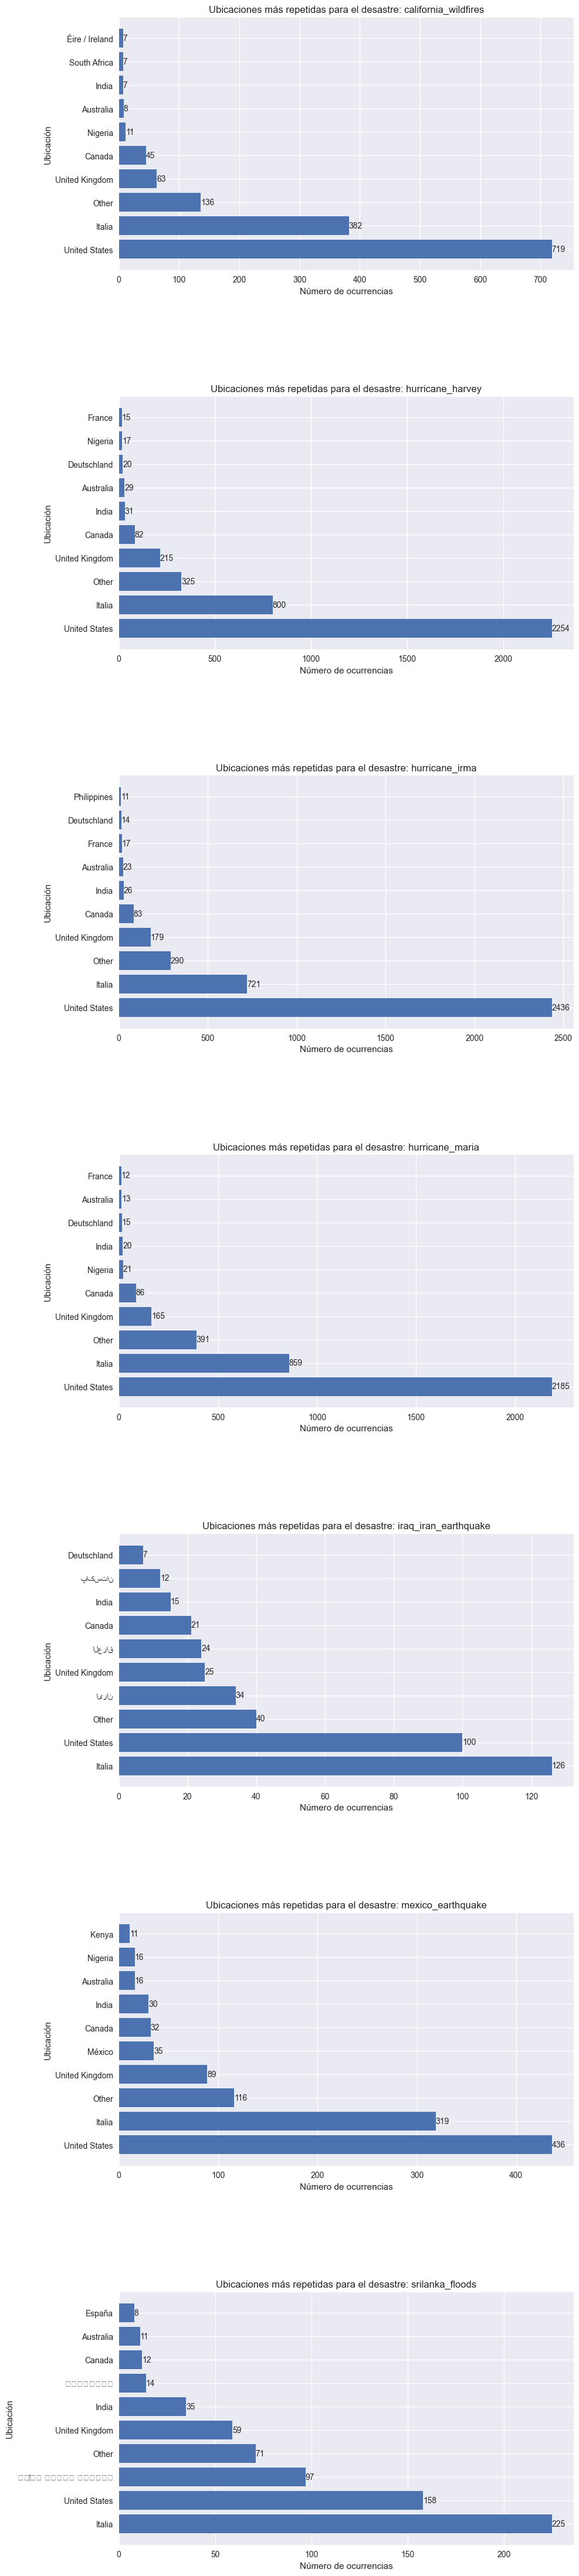

In [ ]:

import matplotlib.pyplot as plt

# Configuración para la generación de gráficos
plt.style.use('seaborn')

# Obtener los nombres de los desastres únicos
desastres = df_counts['json_name'].unique()

# Configuración de los gráficos
fig, axes = plt.subplots(len(desastres), 1, figsize=(10, 8 * len(desastres)))
plt.subplots_adjust(hspace=0.5)  # Espaciado vertical entre los gráficos

# Generar un gráfico de barras para cada desastre
for i, desastre in enumerate(desastres):
    # Filtrar las ubicaciones del desastre actual
    df_desastre = df_counts[df_counts['json_name'] == desastre]
    top_locations_desastre = df_desastre.nlargest(N, 'count')

    # Configurar los datos para el gráfico de barras
    locations = top_locations_desastre['user_location_general']
    counts = top_locations_desastre['count']

    # Configurar el gráfico de barras
    ax = axes[i] if len(desastres) > 1 else axes
    ax.barh(locations, counts)

    # Agregar los números al lado de las barras
    for j, count in enumerate(counts):
        ax.text(count, j, str(count), ha='left', va='center')

    # Configurar etiquetas y título
    ax.set_xlabel('Número de ocurrencias')
    ax.set_ylabel('Ubicación')
    ax.set_title(f'Ubicaciones más repetidas para el desastre: {desastre}')

# Mostrar los gráficos
plt.show()



#### Buscando grupos

       favorite_count  retweet_count  reply_count  quote_count  magnitud
0                   0              0          0.0          0.0     0.078
1                   7              5          0.0          4.0     0.078
2                 289            479          9.0         25.0     0.078
3                 228            216         19.0         18.0     0.078
4                   0              0          0.0          0.0     0.078
...               ...            ...          ...          ...       ...
15219               0              0          0.0          0.0     0.073
15220               0              0          0.0          0.0     0.073
15221               0              0          0.0          0.0     0.073
15222               0              0          0.0          0.0     0.073
15223               0              0          0.0          0.0     0.073

[14895 rows x 5 columns]
[[-0.04637132 -0.04448746 -0.04180685 -0.041147    1.3208504 ]
 [-0.03792488 -0.03284114 -0.041806

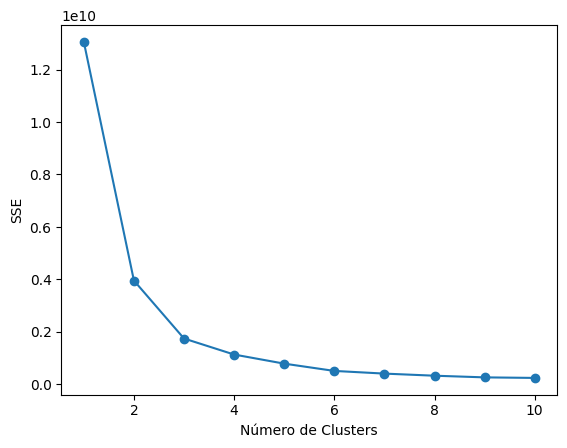

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

mag = {"mexico_earthquake":0.073,
       "hurricane_harvey":0.06,
       "hurricane_irma":0.06,
       "iraq_iran_earthquake":0.107,
       "hurricane_maria":0.046,
       "srilanka_floods":0.03,
       "california_wildfires":0.078}

desastres = ['california_wildfires','hurricane_harvey','hurricane_maria','hurricane_irma','iraq_iran_earthquake','mexico_earthquake']



df2 = df_con_nan.copy()
magnitud = []
for row in df2['json_name']:
    magnitud.append(mag[row])
df2['magnitud'] = magnitud
df2 = df2[df2['json_name'] != 'srilanka_floods']
df2 = df2.select_dtypes(['number'])
df2.drop(["text_human_conf","text_info_conf","id"],axis='columns',inplace=True)

df2 =  df2.dropna()
print(df2)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
df2_scaled = scaler.fit_transform(df2)
print(df2_scaled)
SSE = []
numClusters = list(range(1, 11))
for k in numClusters:
    k_means = KMeans(n_clusters=k, n_init=10, random_state=1)
    k_means.fit(df2)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE, marker="o")
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()


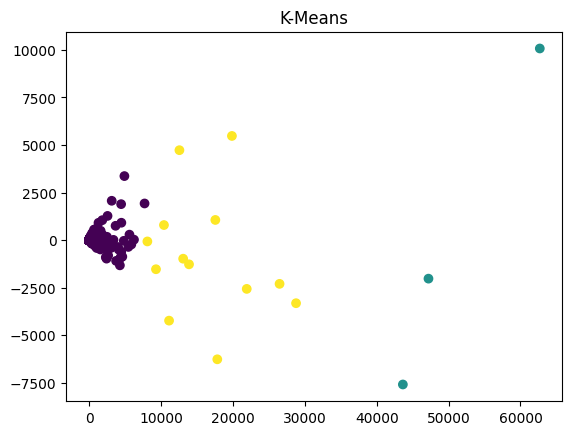

In [ ]:
k = 3

from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=3, max_iter=50, random_state=1, n_init='auto')
kmeans.fit(df2)
pca = PCA(n_components=2).fit(df2)
df_pca = pca.transform(df2) 

#scatter para cada caso


plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans.labels_)
plt.title("K-Means")
plt.show()

In [ ]:
centroids = kmeans.cluster_centers_
pd.DataFrame(centroids, columns=df2.columns)

,favorite_count,retweet_count,reply_count,quote_count,magnitud
0,16.189058,8.913099,0.940789,1.371665,0.060688
1,45792.666667,22862.333333,1807.000000,1157.666667,0.055333
2,14935.692308,6406.153846,315.307692,1047.461538,0.057846


- Grupo 1: Tweets sin mucha relevancia/interacciones
- Grupo 2: Tweets muy 'virales'
- Grupo 3: Tweets con ciertas interacciones

In [ ]:
from sklearn.metrics import silhouette_score

print("Dataset kmeans \t", silhouette_score(df2, kmeans.labels_))

Dataset kmeans 	 0.9968168551242624


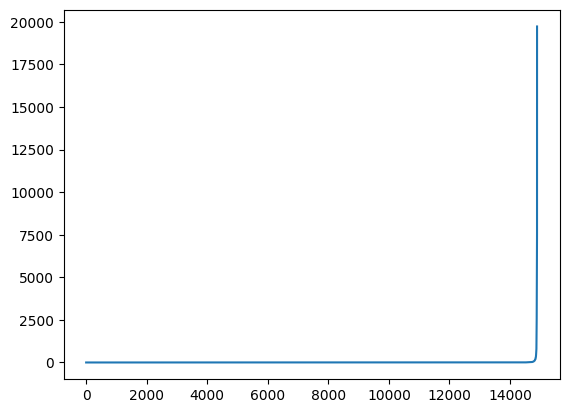

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

N = 5 #corresponde a 'min_samples'

nbrs = NearestNeighbors(n_neighbors=N).fit(df2)
distances, indices = nbrs.kneighbors(df2)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
#plt.axhline(y=11, color='r', linestyle='--') #Ajuste el valor para y
plt.plot(distances)

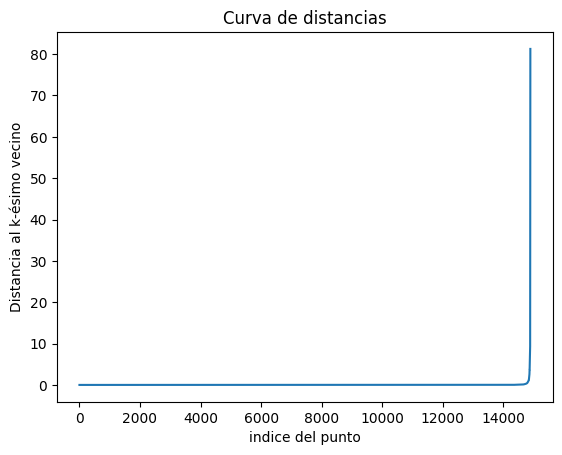

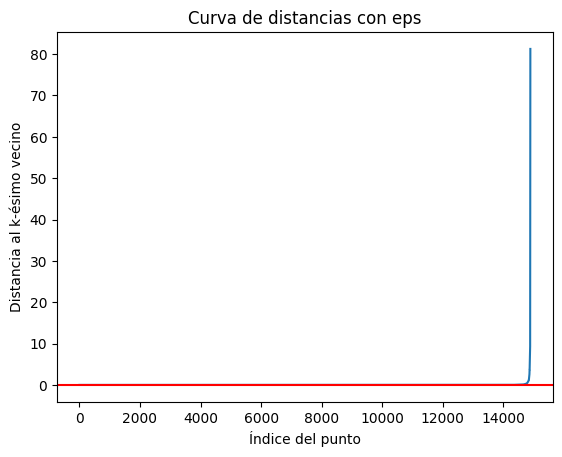

In [ ]:
import numpy as np 
from sklearn.neighbors import NearestNeighbors

min_samples = 5

neigh = NearestNeighbors(n_neighbors=min_samples) 
nbrs = neigh.fit(df2_scaled) 
distances, indices = nbrs.kneighbors(df2_scaled)

distances = np.sort(distances, axis=0) 
distances = distances[:,1]

plt.plot(distances) 
plt.xlabel("indice del punto") 
plt.ylabel("Distancia al k-ésimo vecino") 
plt.title("Curva de distancias") 
plt.show()

eps = distances[5000] 
plt.plot(distances) 
plt.axhline(y=eps, color="r", linestyle="-") 
plt.xlabel("Índice del punto") 
plt.ylabel("Distancia al k-ésimo vecino") 
plt.title("Curva de distancias con eps") 
plt.show()

In [ ]:
# Respuesta
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(df2,'single')
dn = dendrogram(Z)

plt.title("Linkage: ward")
#plt.axhline(y=200, color='r')
plt.show()

: 

: 